# Extracting touristic information from Airbnb guest reviews in Paris

In [1]:
import pandas as pd
from pandas.core.common import flatten
import numpy as  np
import matplotlib.pyplot as plt
import pickle
import os

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import langdetect
import nltk
import unicodedata

from tqdm.notebook import tqdm
tqdm.pandas()

C:\Users\bjxn6144\AppData\Local\Continuum\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Loading the data

#### Load the AirBnB files and check content

The overall process is time consuming due to the very large number of reviews (more than 1.3 millions). You can chose to either run the code on a selection review samples (using the num_samples variable) or preload some precomputed files. 

In [2]:
num_samples = None

original_data_folder = os.path.join('Data', 'Original')
path_to_file = os.path.join(original_data_folder, 'listings.csv')
listing = pd.read_csv(path_to_file, low_memory=False)

path_to_reviews = os.path.join(original_data_folder, 'reviews.csv')
reviews =  pd.read_csv(path_to_reviews, low_memory=False)

# Since the code is very long to execute, we use a sample for testing
if num_samples is not None:
    reviews = reviews.sample(n=num_samples, replace=False)

In [3]:
listing.head(2)

id                            listing_url       scrape_id  \
0  33065009  https://www.airbnb.com/rooms/33065009  20191107231022   
1  33008241  https://www.airbnb.com/rooms/33008241  20191107231022   

  last_scraped                                              name  \
0   2019-11-08  Beautiful apartment center of Paris with terrace   
1   2019-11-08     Magnificent apt located in the heart of Paris   

                                             summary  \
0  Very well located apartment in the heart of Pa...   
1  Beautiful apartment of 22 square meters locate...   

                                               space  \
0  4th floor apartment without elevator with air ...   
1  The accommodation is fully equipped and will p...   

                                         description experiences_offered  \
0  Very well located apartment in the heart of Pa...                none   
1  Beautiful apartment of 22 square meters locate...                none   

                               neighborhood_overview  ... instant_bookable  \
0  This apartment is located in the center of Par...  ...                t   
1                                                NaN  ...                f   

  is_business_travel_ready          cancellation_policy  \
0                        f  strict_14_with_grace_period   
1                        f                     moderate   

  require_guest_profile_picture require_guest_phone_verification  \
0                             f                                f   
1                             f                                f   

   calculated_host_listings_count  \
0                              73   
1                               1   

   calculated_host_listings_count_entire_homes  \
0                                           72   
1                                            1   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            0   

   calculated_host_listings_count_shared_rooms  reviews_per_month  
0                                            0               4.12  
1                                            0               2.18  

[2 rows x 106 columns]

In [4]:
reviews.head(2)

listing_id         id        date  reviewer_id reviewer_name  \
0        3109  123127969  2016-12-27     12389804        Sophie   
1        3109  123274144  2016-12-28     67553494         Tom'S   

                                            comments  
0  The host canceled this reservation the day bef...  
1  The host canceled this reservation 2 days befo...

In [5]:
print('Found {} reviews in total'.format(len(reviews)))

Found 1310351 reviews in total


## Compute some relevant statistics

The file 'insee_stats.txt' was constructed based on the official statistics available on 
https://www.insee.fr/fr/statistiques/1405599?geo=COM-75101 (change 75101 by 750XX where XX represent two digits of the disctrict of interest). The final mapping from district numbers on neighbourhood names is found below (see ngbh_dict variable)

In [6]:
path_to_insee = os.path.join(original_data_folder, 'insee_stats.txt')
with open(path_to_insee, encoding="utf8", errors='ignore') as fichier:
    insee_flats = pd.read_csv(fichier, sep=",")

In [7]:
# Dictionnary mapping zip codes to neighborhoods
ngbh_dict = {'75001':'Louvre', '75002':'Bourse', '75003':'Temple', '75004':'Hôtel-de-Ville', '75005':'Panthéon',\
             '75006':'Luxembourg', '75007':'Palais-Bourbon', '75008':'Élysée', '75009':'Opéra', \
            '75010':'Entrepôt', '75011':'Popincourt', '75012':'Reuilly', '75013':'Gobelins',\
             '75014':'Observatoire','75015':'Vaugirard','75016':'Passy','75017':'Batignolles-Monceau',\
            '75018':'Buttes-Montmartre','75019':'Buttes-Chaumont','75020':'Ménilmontant'}

In [8]:
def compute_airbnb_stats(listing, insee_flats, ngbh_dict):
    """
    Construction of a dataframe containing useful statistics information
    
    IN :
    listing : AirBnB listing of host facilities
    insee_flats : official statistics from Insee, in the form of a precomputed dataframe
    ngbh_dict : dictionnary mapping zip codes to neighborhoods
    
    OUT: 
    dataframe containing useful statistics 
    """
    
    # Compute the number of beds available per neighbourhood
    beds_per_ngb = listing[['neighbourhood_cleansed', 'beds']].groupby('neighbourhood_cleansed').sum()
    beds_per_ngb = beds_per_ngb.reset_index()
    
    # Compute the number of flats available per neighbourhood
    flats_per_ngb = listing[['neighbourhood_cleansed', 'id']].groupby('neighbourhood_cleansed').count()
    flats_per_ngb = flats_per_ngb.reset_index()
    flats_per_ngb.columns = ['Neighbourhood', 'Airbnb_flats']
    airbnb_stats = pd.concat([flats_per_ngb, beds_per_ngb.beds], axis=1)
    
    # Mixing with statistics from Insee
    airbnb_stats = pd.concat([airbnb_stats, insee_flats[['Population', 'Flats']]], axis=1)
    
    # Compute the final useful statistics
    airbnb_stats['Flats percent'] = np.round(airbnb_stats.Airbnb_flats / airbnb_stats.Flats * 100, 1)
    airbnb_stats['Pop. percent'] = np.round(airbnb_stats.beds / airbnb_stats.Population * 100, 1)
    airbnb_stats['Attraction ratio'] = airbnb_stats['Pop. percent'] / airbnb_stats['Airbnb_flats']
    max_attraction_ratio = max(airbnb_stats['Attraction ratio'])
    airbnb_stats['Attraction ratio'] = airbnb_stats['Attraction ratio'] / max_attraction_ratio
    airbnb_stats['Attraction ratio'] = np.round(airbnb_stats['Attraction ratio'], 2)
    
    # Updating the final names of the neighnorhoods
    inv_ngbh_dict = {v:k for k,v in zip(ngbh_dict.keys(),ngbh_dict.values())}
    airbnb_stats['Neighbourhood'] = airbnb_stats['Neighbourhood'].map(lambda x : x+' ('+inv_ngbh_dict[x]+')')
    
    # Computing the same metrics but averaged over the whole city this time
    airbnb_stats_ave = airbnb_stats[['Airbnb_flats', 'beds', 'Population', 'Flats']].mean()
    airbnb_stats_ave['Neighbourhood'] = 'AVERAGE-PARIS'
    airbnb_stats_ave['Flats percent'] = np.round(airbnb_stats_ave.Airbnb_flats / airbnb_stats_ave.Flats * 100, 1)
    airbnb_stats_ave['Pop. percent'] = np.round(airbnb_stats_ave.beds / airbnb_stats_ave.Population * 100, 1)

    airbnb_stats_ave['Attraction ratio'] = airbnb_stats_ave['Pop. percent'] / airbnb_stats_ave['Airbnb_flats']
    airbnb_stats_ave['Attraction ratio'] = airbnb_stats_ave['Attraction ratio'] / max_attraction_ratio
    airbnb_stats_ave['Attraction ratio'] = np.round(airbnb_stats_ave['Attraction ratio'], 2)
    airbnb_stats = airbnb_stats.append(airbnb_stats_ave,ignore_index=True)
    
    return airbnb_stats

In [9]:
airbnb_stats = compute_airbnb_stats(listing, insee_flats, ngbh_dict)
airbnb_stats

Neighbourhood  Airbnb_flats      beds  Population  \
0   Batignolles-Monceau (75017)       4458.00   7123.00   167835.00   
1                Bourse (75002)       2235.00   3997.00    20260.00   
2       Buttes-Chaumont (75019)       3718.00   6254.00   186393.00   
3     Buttes-Montmartre (75018)       7446.00  11279.00   195060.00   
4              Entrepôt (75010)       4595.00   7519.00    91932.00   
5              Gobelins (75013)       2271.00   3715.00   181552.00   
6        Hôtel-de-Ville (75004)       2006.00   3406.00    27487.00   
7                Louvre (75001)       1329.00   2249.00    16252.00   
8            Luxembourg (75006)       1927.00   3511.00    40916.00   
9          Ménilmontant (75020)       3834.00   6161.00   195604.00   
10         Observatoire (75014)       2496.00   4141.00   137105.00   
11                Opéra (75009)       3071.00   5016.00    59629.00   
12       Palais-Bourbon (75007)       1809.00   3127.00    52512.00   
13             Panthéon (75005)       2185.00   3762.00    59108.00   
14                Passy (75016)       3252.00   5854.00   165446.00   
15           Popincourt (75011)       6421.00  10202.00   147017.00   
16              Reuilly (75012)       2667.00   4398.00   141494.00   
17               Temple (75003)       3131.00   5434.00    34788.00   
18            Vaugirard (75015)       4869.00   7893.00   233484.00   
19               Élysée (75008)       1773.00   3212.00    36453.00   
20                AVERAGE-PARIS       3274.65   5412.65   109516.35   

        Flats  Flats percent  Pop. percent  Attraction ratio  
0   105350.00            4.2           4.2              0.09  
1    17252.00           13.0          19.7              0.85  
2    96407.00            3.9           3.4              0.09  
3   121297.00            6.1           5.8              0.08  
4    59566.00            7.7           8.2              0.17  
5   103862.00            2.2           2.0              0.08  
6    22813.00            8.8          12.4              0.60  
7    13797.00            9.6          13.8              1.00  
8    31517.00            6.1           8.6              0.43  
9   106522.00            3.6           3.1              0.08  
10   83442.00            3.0           3.0              0.12  
11   40648.00            7.6           8.4              0.26  
12   39615.00            4.6           6.0              0.32  
13   39659.00            5.5           6.4              0.28  
14  102686.00            3.2           3.5              0.10  
15   99788.00            6.4           6.9              0.10  
16   86406.00            3.1           3.1              0.11  
17   26108.00           12.0          15.6              0.48  
18  150580.00            3.2           3.4              0.07  
19   27060.00            6.6           8.8              0.48  
20   68718.75            4.8           4.9              0.14

### Visualization of relevant statistics

#### Total number of AirBnB flats per neighbourhood

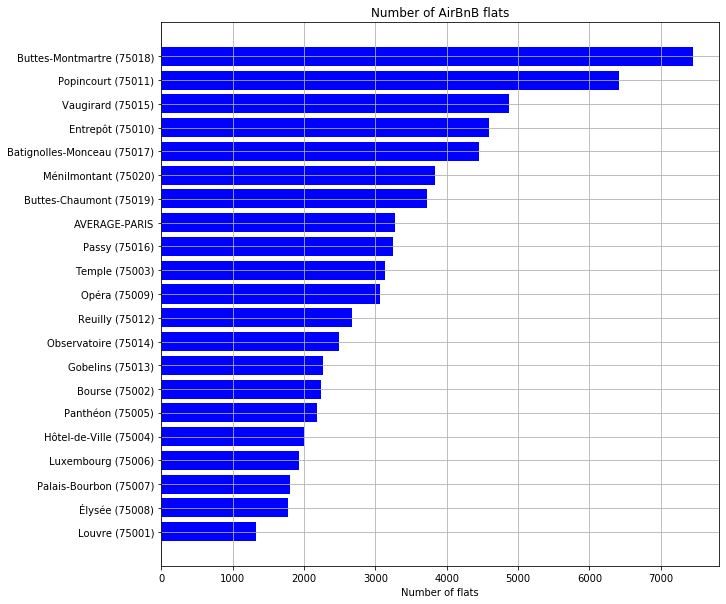

In [62]:
features = airbnb_stats['Neighbourhood'].values
importances = airbnb_stats['Airbnb_flats']

indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10,10))
plt.title('Number of AirBnB flats')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Number of flats')
plt.grid()
plt.show()

#### Percentage of AirBnB flats relative to the total number of flats

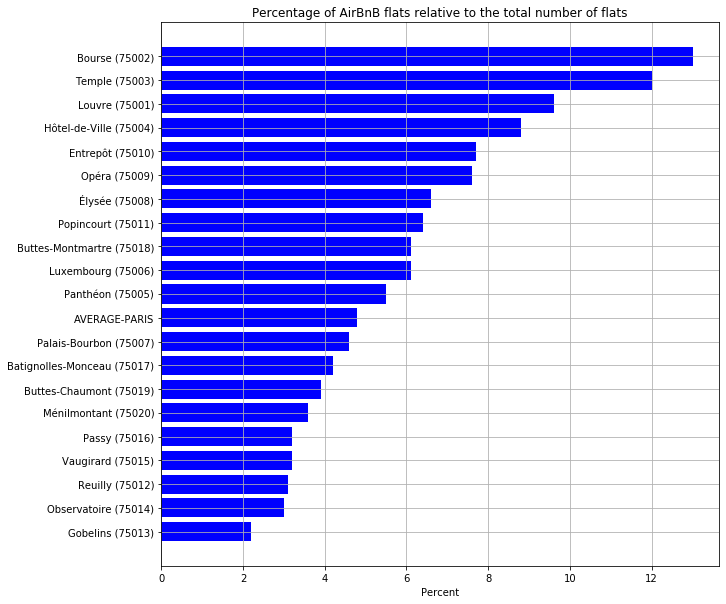

In [11]:
features = airbnb_stats['Neighbourhood'].values
importances = airbnb_stats['Flats percent']

indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10,10))
plt.title('Percentage of AirBnB flats relative to the total number of flats')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Percent')
plt.grid()
plt.show()

#### Percentage of AirBnB beds relative to the population

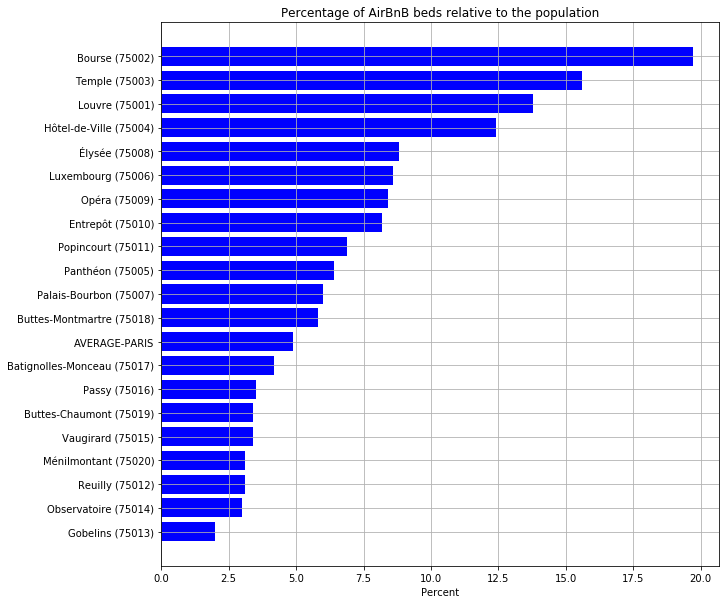

In [12]:
features = airbnb_stats['Neighbourhood'].values
importances = airbnb_stats['Pop. percent']

indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10,10))
plt.title('Percentage of AirBnB beds relative to the population')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Percent')
plt.grid()
plt.show()

#### Neighbourhood attraction ratio

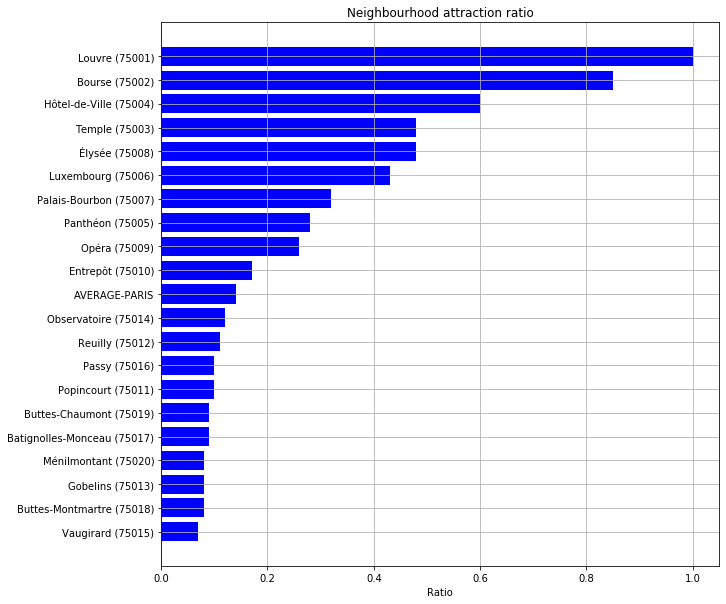

In [13]:
features = airbnb_stats['Neighbourhood'].values
importances = airbnb_stats['Attraction ratio']

indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10,10))
plt.title('Neighbourhood attraction ratio')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Ratio')
plt.grid()
plt.show()

## Reviews filtering

Before processing the reviews set, we make the following filtering:  
* Since most of the reviews are in english, we choose to select only the reviews in english. For this, we use the package 'langdetect'. 
* We discard the reviews that are automatically posted by a bot and can be found through the pattern 'This is an automated posting'. 
* We keep only reviews containing text

In [14]:
def assess_language(text):
    """
    Returns the language detected in a tex when applicable.
    """
    try:
        x = langdetect.detect(text)
    except:
        x = np.nan
    return x

In [15]:
def select_reviews(text):
    """
    Selects the review of interest for the analysis : written in english, not written by a bot.
    """
    if (type(text) is not str) or ('This is an automated posting' in text) or (assess_language(text) != 'en'):
        return np.nan
    else:
        return text

The selection is very time consuming. To gain time, we use the saved index of the corresponding process. 

In [16]:
path_to_pickles = os.path.join('Data', 'Saved')
path_to_dataindex = os.path.join(path_to_pickles, 'DataIndex.pickle')

if os.path.exists(path_to_dataindex) and num_samples is None:
    DataIndex = pickle.load(open(path_to_dataindex, 'rb'))
    reviews_english = reviews.iloc[DataIndex].copy()
else:
    reviews_english = reviews.copy()
    reviews_english['comments'] = reviews_english['comments'].progress_apply(select_reviews)
    reviews_english = reviews_english.dropna(subset=['comments'])
    if num_samples is None:
        pickle.dump(reviews_english.index, open(path_to_dataindex, 'wb'))

In [17]:
print('Found {} reviews written in english'.format(len(reviews_english)))

Found 795721 reviews written in english


#### Add the neighbourhood information to the dataframe and remove some non-useful columns

__Keep only useful columns__

In [18]:
reviews_english = reviews_english[['listing_id', 'date', 'comments']]

In [19]:
def get_neighbourhood(row, listing=listing):    
    """
    Returns the neighbourhood of a review by searching for it in the listing file. 
    """
    neighbourhood_series = listing[listing['id'] == row['listing_id']].neighbourhood_cleansed
    if len(neighbourhood_series)>0:
        return neighbourhood_series.values[0]
    else:
        return np.nan

In [20]:
reviews_english['Neighbourhood'] = reviews_english.progress_apply(get_neighbourhood, axis=1)

#### Keep only useful columns

In [21]:
reviews_english = reviews_english[['date', 'comments', 'Neighbourhood']]

In [22]:
reviews_english.head()

date                                           comments  \
5  2010-03-27  I booked this apartment for my four friends an...   
6  2010-04-11  I love the appartment as it is very cute with ...   
7  2010-05-13  The apartment is very charming. My teenage dau...   
8  2010-05-24  This  delightful little nest was perfect for u...   
9  2010-06-20  Karen is a wonderful host, after greeting us w...   

       Neighbourhood  
5  Buttes-Montmartre  
6  Buttes-Montmartre  
7  Buttes-Montmartre  
8  Buttes-Montmartre  
9  Buttes-Montmartre

## Stopwords from Gensim to be filtered out:

In [23]:
STOPWORDS = gensim.parsing.preprocessing.STOPWORDS

In [24]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('french')).union(STOPWORDS)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bjxn6144\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
def remove_accents(x):
    return ''.join((c for c in unicodedata.normalize('NFD', x) if unicodedata.category(c) != 'Mn'))

## Host names to be removed. 
The analysis can be biased by the hosts names that often appear in the reviews. To cope with this issue, we remove all names found in the reviews with the help of the list below. 



In [26]:
def construct_name(x):
    """
    When applicable, splits a text into tokens.
    This is applied to the listing['host_name'] column to get the components of the hosts names. 
    """
    try:
        z = gensim.utils.simple_preprocess(x)
    except:
        z = np.nan
            
    return z

Extract names from the listing host data and do some cleaning

In [27]:
# names no to be filtered out because they are present also in famous places from Paris
names_to_keep = {'roland', 'germain', 'dame', 'louis', 'jourdain', 'champs', 'charles', 'paris', 'montmartre'}

In [28]:
# names to add because they were captured by the filtering and appear in the results.
# This list was obtained after iterations on the results
names_to_add = {'nazeem', 'polyna', 'monic', 'lolotte', 'henley', 'mami', 'mychele', 'pat','kat', 'venie', 'ysa',\
          'germaine', 'siyoung', 'bouzra', 'khal', 'jojo', 'zanne', 'yas', 'elo', 'segire', 'aki',\
          'welly', 'ebe', 'suomi', 'sweet inn', 'segolene', 'corrine', 'regine', 'vale', 'jen', 'marie-anne',\
        'anne-sophie', 'jp', 'jean-paul', 'jean-marc', 'anne-charlotte', 'jean-pierre', 'jc', 'maitis',\
                'jean-michel', 'cat cute', 'jean-michel', 'anne-marie', 'jean-luc', 'noelle', 'jean-louis',\
                'jb', 'jean-francois', 'rumi', 'jean-claude', 'marie-christine', 'osaka', 'fralma', 'fralmas',\
                'sono', 'm4', 'sl', 'sichen', 'hag', 'jean-baptiste', 'andree', 'dd', 'val', 'jm', 'lidl',\
               'charles', 'ale', 'barge', 'jean-françois', 'cheer'}

Below, we construc in all_names both real names and other tokens that are not names. For further filtering, we will load a database of french names and keep only the elements of all_names that are present in this list.
The following file was extracted from https://www.insee.fr/fr/statistiques/2540004 which contains all the names that were given in France since early 1900. 

In [29]:
insee_names = pd.read_csv('./Data/Original/nat2018.csv', sep=';')
all_names_insee = (insee_names.preusuel.values)
all_names_insee = set([x.lower() for x in all_names_insee if type(x)==str and len(x)>1])

In [30]:
def get_names_to_filter(listing, names_to_keep, names_to_add, all_names_insee):
    """
    Obtain a list of names to be filtered out from the reviews because they correspond to host names
    
    IN : 
    listing : AirBnB listing of host facilities
    names_to_keep : names we should not filter out
    names_to_add : names we should add to the filtering
    all_names_insee : official names from Insee, in the form of a precomputed set
    
    OUT: 
    all_names : set of all names to be filtered out
    """
    names = listing['host_name'].apply(construct_name)
    
    # We flatten the list of host names into a list
    all_names = set(flatten(list(names.values)))
    all_names.discard(np.nan)
    
    # We discard some elements that represent also famous places from Paris
    all_names = all_names.difference(names_to_keep)

    # For some names like Jean-Marc, we can have spelling error and find it as Jean Marc. 
    # Therefore we add these derived names to the names list
    derived_names = set()
    for x in all_names:
        derived_names.add(' '.join(x.split('-')))

    all_names = all_names.union(derived_names)
    # all_names = set(all_names)
    
    # At this point, we have in all_names both real names and other tokens that are not names. 
    # For further filtering, we load a database of french names and keep only the elements of all_names
    # that are present in this list.
    # The following file was extracted from https://www.insee.fr/fr/statistiques/2540004 which contains
    # all the names that were given in France since early 1900. 
    all_names = all_names.intersection(all_names_insee)

    all_names = all_names.union(names_to_add)
    
    for x in list(all_names):
        all_names.add(remove_accents(x))
        
    return all_names

In [31]:
all_names = get_names_to_filter(listing, names_to_keep, names_to_add, all_names_insee)

In [32]:
print('Found {} names to filter out from the reviews'.format(len(all_names)))

Found 5348 names to filter out from the reviews


## Entity name recognition

We provide below the functions that permit to do tokenization, and then we provide some examples to understand how the code works.

In [33]:
import nltk
import codecs

sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [34]:
def build_tokens(sentence):
    """
    From a sentence tokenized by nltk, build a list of tokens.
    We use filering of host names and grouping of entities representing locations. 
    
    IN : 
    _________________________________________
    sentence tokenized by nltk
    
    RETURN : 
    _________________________________________
    list of tokens
    """
    all_tokens = []
    current_token = []
    articles = {'the', 'le', 'les', 'à', 'a', 'aux', 'au'}
    
    ii = 0
    while ii<len(sentence):
        if  sentence[ii][1] == 'NNP' and sentence[ii][0].lower() not in articles\
        and sentence[ii][0].lower() not in all_names and len(sentence[ii][0])>1:
            while ii<len(sentence) and sentence[ii][1] == 'NNP':
                current_token.append(sentence[ii][0].lower())
                ii+=1
            if ii<len(sentence) and sentence[ii][0].lower() in articles:
                current_token.append(sentence[ii][0].lower())
                ii+=1      
                while ii<len(sentence) and sentence[ii][1] == 'NNP':
                    current_token.append(sentence[ii][0].lower())
                    ii+=1
            current_token = ' '.join([x for x in current_token])
            if current_token.lower() != 'paris' and current_token.lower() not in all_names:
                all_tokens.append(current_token)
            current_token = []
        else:
            x = sentence[ii][0].lower()
            x = remove_accents(x)
            if x.isalpha() and x not in STOPWORDS and x != 'paris' and x not in all_names:
                all_tokens.append(x)
            ii += 1
                
    return all_tokens

In [35]:
def tags_to_token(pos_tagged_sents):
    """
    Concatenates the results of several sentences tokenization
    
    Input : List of words with their tokens, output from nltk tokenizer (see example below)
    Output : list of tokens of the review
    """

    all_tokens = []
    for sentence in pos_tagged_sents:
        all_tokens += build_tokens(sentence)
        
    return all_tokens

In [36]:
def review_to_token(review):
    """
    High level function. Calls the nltk tokenizer and call the low level functions that constructs tokens.
    
    IN : one review
    Out : the tokens
    """
    
    try:
        sentences = sentence_tokenizer.tokenize(review)
        tok_sentences = [nltk.word_tokenize(s) for s in sentences]
        
        pos_tagged_sents = []
        for s in tok_sentences:
            tmp = nltk.pos_tag(s)
            pos_tagged_sents.append(tmp)
            
        tokens = tags_to_token(pos_tagged_sents)
        
    except:
        print('ERROR')
        print(review)
        print('_'*50)
        tokens = np.nan
        
    return tokens
            

__Final result illustration__ : we can see below that 'notre dame' and 'ile st. louis' are recognized as unbreakable entities.

In [37]:
review = 'Perfect place to be in Paris, walking home every night past Notre Dame and across the river \
through the old streets of the Ile St. Louis. The studio is just right- attractive, immaculate, \
with everything you could need.'
review_to_token(review)

['perfect',
 'place',
 'walking',
 'home',
 'night',
 'past',
 'notre dame',
 'river',
 'old',
 'streets',
 'ile st. louis',
 'studio',
 'attractive',
 'immaculate',
 'need']

__Intermediate result illustration__ : vizualizing the result of the nltk tokenizer

In [38]:
sentences = sentence_tokenizer.tokenize(review)
tok_sentences = [nltk.word_tokenize(s) for s in sentences]

pos_tagged_sents = []
for s in tok_sentences:
    tmp = nltk.pos_tag(s)
    pos_tagged_sents.append(tmp)

In [39]:
pos_tagged_sents

[[('Perfect', 'JJ'),
  ('place', 'NN'),
  ('to', 'TO'),
  ('be', 'VB'),
  ('in', 'IN'),
  ('Paris', 'NNP'),
  (',', ','),
  ('walking', 'VBG'),
  ('home', 'NN'),
  ('every', 'DT'),
  ('night', 'NN'),
  ('past', 'IN'),
  ('Notre', 'NNP'),
  ('Dame', 'NNP'),
  ('and', 'CC'),
  ('across', 'IN'),
  ('the', 'DT'),
  ('river', 'NN'),
  ('through', 'IN'),
  ('the', 'DT'),
  ('old', 'JJ'),
  ('streets', 'NNS'),
  ('of', 'IN'),
  ('the', 'DT'),
  ('Ile', 'NNP'),
  ('St.', 'NNP'),
  ('Louis', 'NNP'),
  ('.', '.')],
 [('The', 'DT'),
  ('studio', 'NN'),
  ('is', 'VBZ'),
  ('just', 'RB'),
  ('right-', 'JJ'),
  ('attractive', 'JJ'),
  (',', ','),
  ('immaculate', 'JJ'),
  (',', ','),
  ('with', 'IN'),
  ('everything', 'NN'),
  ('you', 'PRP'),
  ('could', 'MD'),
  ('need', 'VB'),
  ('.', '.')]]

### Obtaining one big review per neighbourhood

In the process below, we build 20 big reviews, one per neighbourhood, and save them in a new compact dataframe review_concat.

In [40]:
path_to_review_concat = os.path.join(path_to_pickles, 'review_concat.pickle')

if os.path.exists(path_to_review_concat) and num_samples is None:
    review_concat = pickle.load(open(path_to_review_concat, 'rb'))
else:
    print('review_to_token:')
    reviews_english['tokens'] = reviews_english['comments'].progress_apply(review_to_token)
    print('review_concat:')
    review_concat = reviews_english[['Neighbourhood', 'tokens']].groupby('Neighbourhood').progress_apply(lambda x :x.sum())
    if num_samples is None:
        pickle.dump(review_concat, open(path_to_review_concat, 'wb'))

### TF-IDF vectorizer

In [41]:
def dummy_fun(doc):
    """
    Used to be able to apply TfidfVectorizer to lists
    """
    return doc

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

VocabSize = 2000
corpus = list(review_concat['tokens'].values)

vectorizer = TfidfVectorizer(max_df=0.9,
                             min_df=5,
                             analyzer = 'word', 
                             tokenizer = dummy_fun,
                             preprocessor = dummy_fun,
                             max_features=VocabSize, 
                             ngram_range=(1, 3), 
                             token_pattern=None)
X = vectorizer.fit_transform(corpus)

In [43]:
DfW = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names())
DfW.index = review_concat.index

In [44]:
DfW

able drop bags  able walk eiffel tower  able walk louvre  \
Neighbourhood                                                                   
Batignolles-Monceau        0.000648                0.002484          0.000000   
Bourse                     0.010814                0.001884          0.020902   
Buttes-Chaumont            0.001614                0.000000          0.000000   
Buttes-Montmartre          0.002738                0.000000          0.000256   
Entrepôt                   0.002186                0.000000          0.001062   
Gobelins                   0.000000                0.000000          0.000000   
Hôtel-de-Ville             0.002100                0.000671          0.004464   
Louvre                     0.007030                0.001796          0.010249   
Luxembourg                 0.006804                0.003161          0.018035   
Ménilmontant               0.003531                0.000000          0.000000   
Observatoire               0.000000                0.003417          0.000000   
Opéra                      0.005840                0.000746          0.006386   
Palais-Bourbon             0.005252                0.013979          0.004785   
Panthéon                   0.003275                0.000000          0.000884   
Passy                      0.001794                0.019859          0.000726   
Popincourt                 0.003485                0.000495          0.000000   
Reuilly                    0.005545                0.000000          0.001347   
Temple                     0.005340                0.000890          0.001692   
Vaugirard                  0.003441                0.017147          0.000418   
Élysée                     0.003844                0.009821          0.004670   

                     able walk major  able walk wanted  able watch  \
Neighbourhood                                                        
Batignolles-Monceau         0.000000          0.003241    0.000648   
Bourse                      0.010230          0.008357    0.003932   
Buttes-Chaumont             0.000000          0.000000    0.000000   
Buttes-Montmartre           0.000487          0.000632    0.001685   
Entrepôt                    0.001011          0.002186    0.001968   
Gobelins                    0.000000          0.000000    0.002983   
Hôtel-de-Ville              0.004552          0.003937    0.000787   
Louvre                      0.007316          0.007030    0.002109   
Luxembourg                  0.012873          0.009897    0.004330   
Ménilmontant                0.000000          0.000883    0.002648   
Observatoire                0.000000          0.005350    0.002675   
Opéra                       0.005402          0.005256    0.002920   
Palais-Bourbon              0.006578          0.006127    0.006565   
Panthéon                    0.003787          0.003639    0.001819   
Passy                       0.002074          0.003587    0.003587   
Popincourt                  0.000896          0.002324    0.003098   
Reuilly                     0.003846          0.002218    0.000000   
Temple                      0.003490          0.004411    0.000697   
Vaugirard                   0.001592          0.001377    0.006883   
Élysée                      0.005925          0.008968    0.003844   

                     absolute perfect  absolutely amazing location  \
Neighbourhood                                                        
Batignolles-Monceau          0.004760                     0.002040   
Bourse                       0.003610                     0.006189   
Buttes-Chaumont              0.001129                     0.000000   
Buttes-Montmartre            0.001989                     0.001989   
Entrepôt                     0.001376                     0.000459   
Gobelins                     0.006260                     0.000000   
Hôtel-de-Ville               0.005783                     0.004957   
Louvre                       0.010326                     0.009589 

## Obtaining the final colored maps 

For each neighbourhood, we keep the 150 most significant ngrams. 
For a better result, we introduce several levels of filtering that were chosen in an iterative way:  
* First, we remove all items that corresponds to names that were not captured before
* Secondly, we perform some specific key removals for keys appearing multiple times in different notations
* Third, we use a famous place dictionnary to regroup the famous keys into single representants 
* Finally, we remove all items that are included in an other item if it has a significant tf-idf value

For monitoring the filtering process, we added some logging where we put the rule number, the removed key, the cause of removal, and the number of times it has been applied. 

In [45]:
# Format : 'Key to be kept':{set of keys to be removed}
inv_famous_places = {'Place des Vosges': {'vosges'},
 'Châtelet':{'chatelet', 'châtelet'},
 'Ile St-Louis': {'ile '},
 'Arc de Triomphe': {' arc', ' arch', 'arch', 'triomph', 'triumph'},
 'Montmartre': {'montmartre', 'monmartre','montmatre', 'montemarte', 'monmarte', 'mont martre', 'monmatre'},
 'Champs-Elysées': {'elysee'},
 'Moulin Rouge': {'moulin'},
 'Eiffel Tower': {'eiffel', 'effel ', 'effel'},
 'Louvre': {'louvre', 'louve', 'lourve'},
 'Les Halles': {'halles'},
 'Pompidou Center': {'pompidou'},
 'Canal St-Martin': {'canal'},
 'Buttes Chaumont': {'chaumont'},
 'Sacré Coeur': {'sacre', 'sacré', 'couer'},
 'République': {'republique', 'république', 'republic'},
 'Marais': {'marais'},
 'Notre Dame': {'notre'},
 'St.Germain': {'germain', ' prés'},
 'St.Sulpice': {'sulpice'},
 'Luxembourg Garden': {'luxembourg', 'luxemburg'},
 'Père Lachaise cemetery': {'lachaise'},
 'Galeries Lafayette': {'lafayette'},
 'rue Mouffetard': {'mouffetard'},
 'Quartier Latin': {'latin'},
 'Jardin des Plantes': {'plantes'},
 'Bastille': {'bastille'},
 'Opéra': {'opera'}, 
 'Tuileries Garden': {'tuilerie'}, 
 'Hôtel de Ville':{'hotel ', 'hôtel', 'ville '},
 'Trocadéro':{'trocadero', 'trocadéro'},
 'Concorde':{'concorde'},
 'rue de Rivoli':{'rivoli'}}

In [46]:
def filter_famous(elected_name, vibrations_dict, inv_famous_places, log_on=True):
    """
    Filtering of famous places using the famous places dictionnary
    IN : current dictionnary of keys - tfidf
    OUT: filtered dictionnary of keys - tfidf
    """
    to_replace = set()

    for k in inv_famous_places[elected_name]:
        to_replace_loc = {x for x in vibrations_dict.keys() if k in x}
        to_replace = to_replace.union(to_replace_loc)
        
    if len(to_replace):

        new_key = elected_name
        new_value = max(vibrations_dict[to_replace])    

        for k in to_replace:
            if log_on:
                print('3. Removed ', k, ', cause : ', elected_name)  
            (vibrations_dict).pop(k)

        vibrations_dict[new_key] = new_value
        if log_on:
            print('3. CREATED NEW KEY ', new_key, ', value : ', new_value)  
            for k in to_replace:
                if k in vibrations_dict.keys():
                    print('FALSE')
        
    return vibrations_dict

In [47]:
def process_tower(vibrations_dict, log_on=True):
    """
    Specific filtering for 'tower' keys
    IN : current dictionnary of keys - tfidf
    OUT: filtered dictionnary of keys - tfidf
    """
    to_check = {x for x in vibrations_dict.keys() if 'tower' in x}
    for k in to_check:
        if 'montparnasse' not in k and 'eiffel' not in k:
            value_loc = vibrations_dict[k]
            (vibrations_dict).pop(k)
            vibrations_dict[' eiffel '+k] = value_loc
            if log_on:
                print('0T. Removed ', k, ', replaced by : ', ' _eiffel_ '+k)  
            
    return vibrations_dict

In [48]:
def process_champs(vibrations_dict, log_on=True):
    """
    Specific filtering for 'champs' keys
    IN : current dictionnary of keys - tfidf
    OUT: filtered dictionnary of keys - tfidf
    """
    to_check = {x for x in vibrations_dict.keys() if 'champ' in x}
    
    for k in to_check:
        
        if 'mars' not in k:

            new_key = '_elysee_ '+k
            new_value = vibrations_dict[k]    

            if log_on:
                print('0C. Removed ', k, ', cause : ', 'champs')  
            (vibrations_dict).pop(k)

            vibrations_dict[new_key] = new_value
            if log_on:
                print('0C. CREATED NEW KEY ', new_key, ', value : ', new_value)  

            
    return vibrations_dict

In [49]:
def process_champs_mars(vibrations_dict, log_on=True):
    """
    Another specific filtering for 'champs' keys
    IN : current dictionnary of keys - tfidf
    OUT: filtered dictionnary of keys - tfidf
    """
    to_replace = {x for x in vibrations_dict.keys() if 'champ' in x and 'mars' in x}
    
    if len(to_replace):    
        
        new_key = 'Champs de Mars'
        new_value = vibrations_dict[to_replace].max()   
    
        for k in to_replace:
            if log_on:
                print('0 Ch. Removed ', k, ', cause : ', new_key)  
            (vibrations_dict).pop(k)

        vibrations_dict[new_key] = new_value

            
    return vibrations_dict

In [50]:
def process_gare(vibrations_dict, log_on=True):
    """
    Another specific filtering for 'gare' keys
    IN : current dictionnary of keys - tfidf
    OUT: filtered dictionnary of keys - tfidf
    """
    to_replace = {x for x in vibrations_dict.keys() if 'gare' in x} 

    if len(to_replace):      
        new_key = vibrations_dict[to_replace].idxmax()
        new_value = vibrations_dict[to_replace].max()   
    
        for k in to_replace:
            if log_on:
                print('0G. Removed ', k, ', cause : ', new_key)  
            (vibrations_dict).pop(k)

        vibrations_dict[new_key] = new_value
            
    return vibrations_dict

In [51]:
def process_host_names(vibrations_dict, all_names = all_names, log_on=True):
    """
    Residual hostnames filtering 
    IN : current dictionnary of keys - tfidf
    OUT: filtered dictionnary of keys - tfidf
    """    
    to_replace = set()

    for name in all_names:
        to_replace_loc = {x for x in vibrations_dict.keys() if x == name}
        to_replace = to_replace.union(to_replace_loc) 
        
    if len(to_replace):
        for k in to_replace:
            if log_on:
                print('1. Removed ', k, ', cause : ', k)  
            (vibrations_dict).pop(k)
            
    return vibrations_dict

In [52]:
def construct_vibrations(DfW, inv_famous_places, all_names, th_include=0.2, log_on = False):
    """
    Construct one dictionnary per neighborhood containing the most relevant keys, after filtering and grouping
    
    IN:
    DfW : TF-IDF dataframe
    inv_famous_places : dictionnary permitting to filter and group keys relevant for famous place of Paris
    all_names : set of names to be removed
    th_include : threshold permitting to tune the filtering. Value obtain by iterations. 
    log_on : log option
    
    OUT:
    vibrations_filtered : dictionnary per neighborhood containing the most relevant keys
    """
    vibrations_filtered = {}

    for q in DfW.index:
        # Compute tf-idf dictionnary for neighbourhood q
        vibrations_filtered[q] = DfW.loc[q].sort_values(ascending=False)   

        if log_on:
            print('===============================================================================')
            print('=================  STARTING  '+q+'=============================')
            print('===============================================================================')
        vibrations_filtered[q] = process_host_names(vibrations_filtered[q], all_names, log_on=log_on)
        vibrations_filtered[q] = process_gare(vibrations_filtered[q], log_on=log_on)
        vibrations_filtered[q] = process_tower(vibrations_filtered[q], log_on=log_on) 
        vibrations_filtered[q] = process_champs_mars(vibrations_filtered[q], log_on=log_on)
        vibrations_filtered[q] = process_champs(vibrations_filtered[q], log_on=log_on)
        for famous in inv_famous_places.keys():
            vibrations_filtered[q] = filter_famous(famous, vibrations_filtered[q],\
                                                   inv_famous_places, log_on=log_on)

        # Remove keys included in others
        for k in (vibrations_filtered[q]).keys():
            for k2 in (vibrations_filtered[q]).keys():
                if k2 is not k and k in k2.split() and vibrations_filtered[q][k2]>=th_include*vibrations_filtered[q][k]: 
                    if log_on:
                        r2+=1
                        print('2. Removed ', k, ', cause : ', k2, r2)
                    vibrations_filtered[q][k2] = max(vibrations_filtered[q][k], vibrations_filtered[q][k2])
                    (vibrations_filtered[q]).pop(k)
                    break  
                    
        # Final fine tuning based on further iterations
        if 'walk gare nord' in vibrations_filtered[q].keys():
            vibrations_filtered[q]['gare du nord'] = vibrations_filtered[q].pop('walk gare nord')
        
        if 'Champs de Mars' in vibrations_filtered[q].keys() and 'mars' in vibrations_filtered[q].keys():
            vibrations_filtered[q]['Champs de Mars'] = \
                max(vibrations_filtered[q]['Champs de Mars'], vibrations_filtered[q]['mars'])
            vibrations_filtered[q].pop('mars')
                    
        if log_on:
            print('===============================================================================')
            print('=================  FINISHED  '+q+'=============================')
            print('===============================================================================')
            
    return vibrations_filtered

In [53]:
vibrations_filtered = construct_vibrations(DfW, inv_famous_places, all_names)

#### Final construction of word couds



####################          BATIGNOLLES-MONCEAU:          ####################




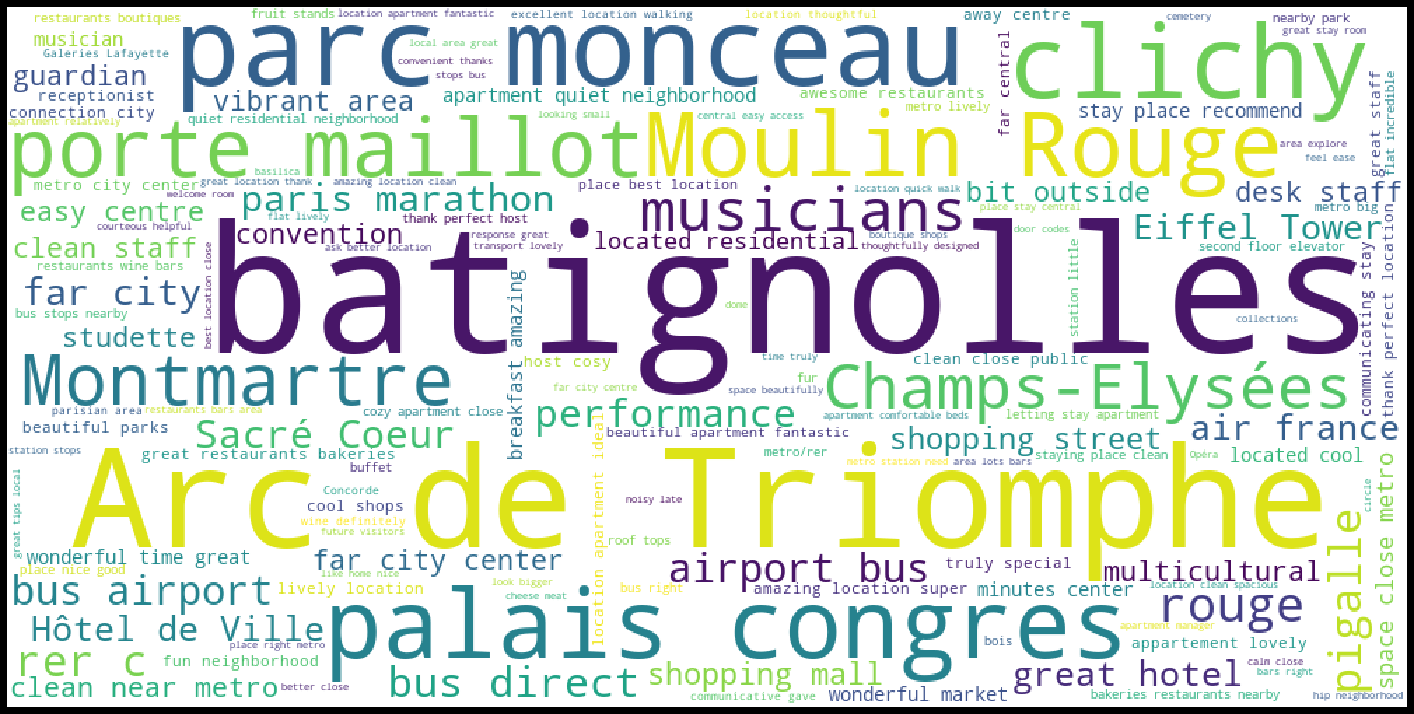



####################          BOURSE:          ####################




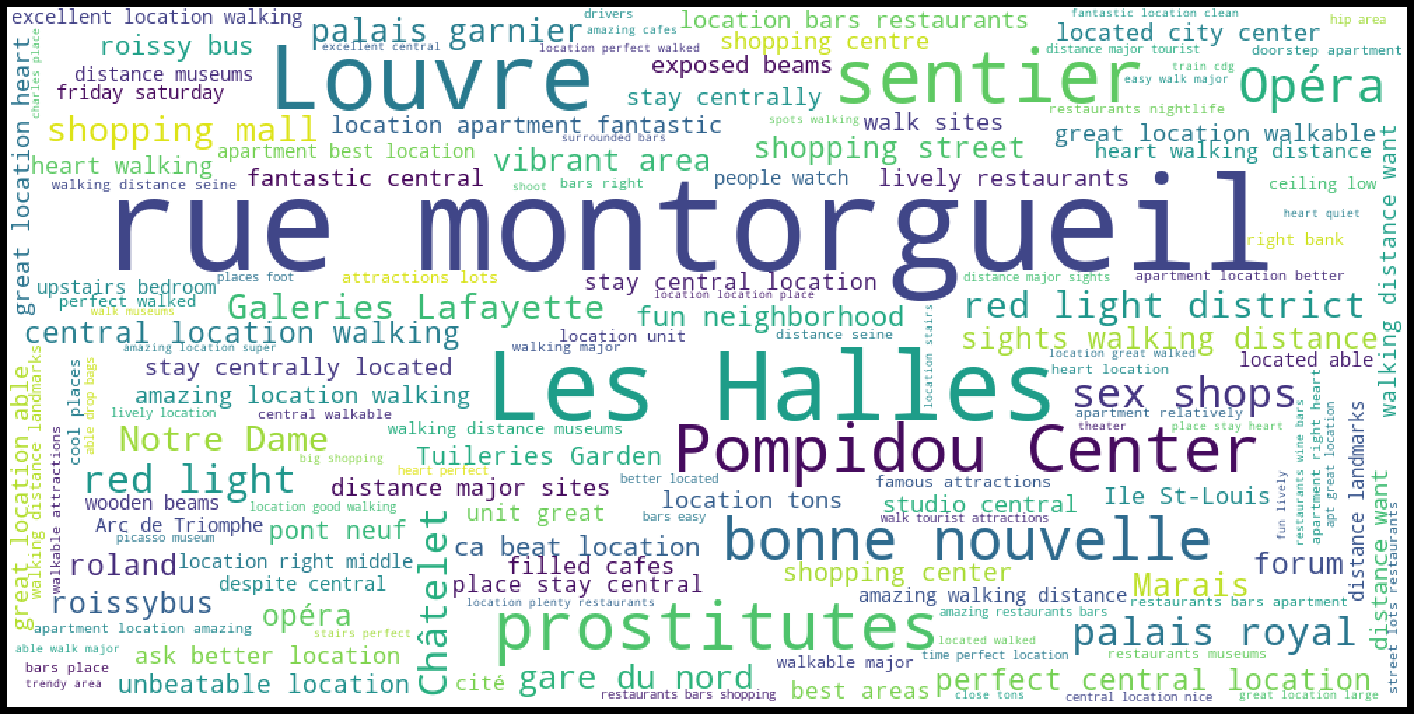



####################          BUTTES-CHAUMONT:          ####################




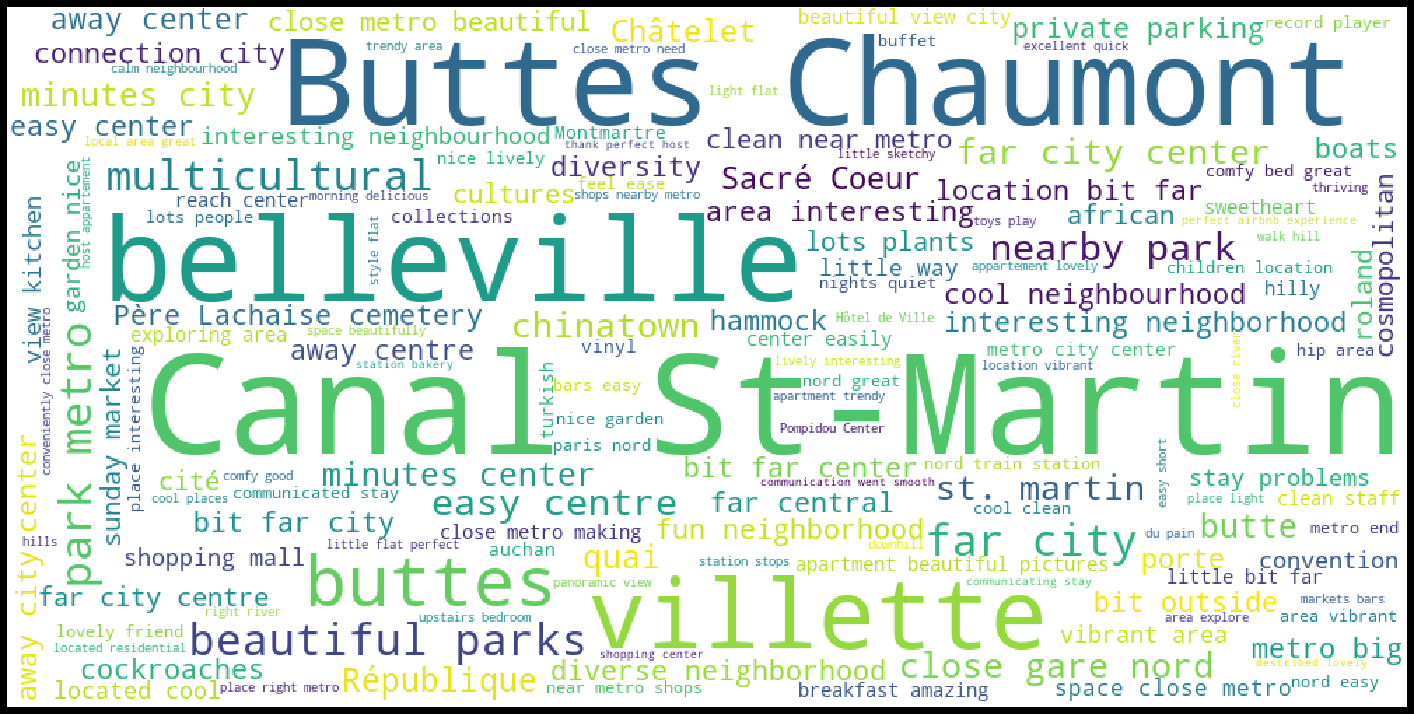



####################          BUTTES-MONTMARTRE:          ####################




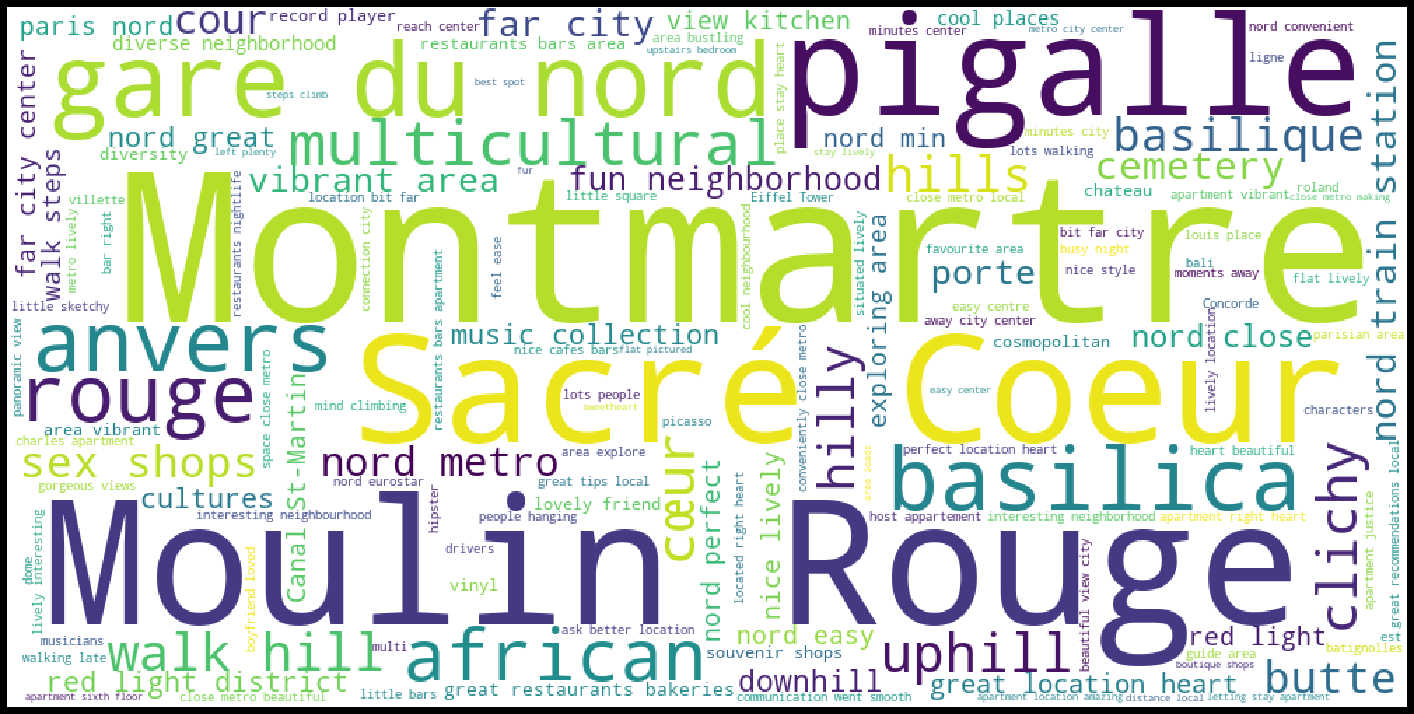



####################          ENTREPÔT:          ####################




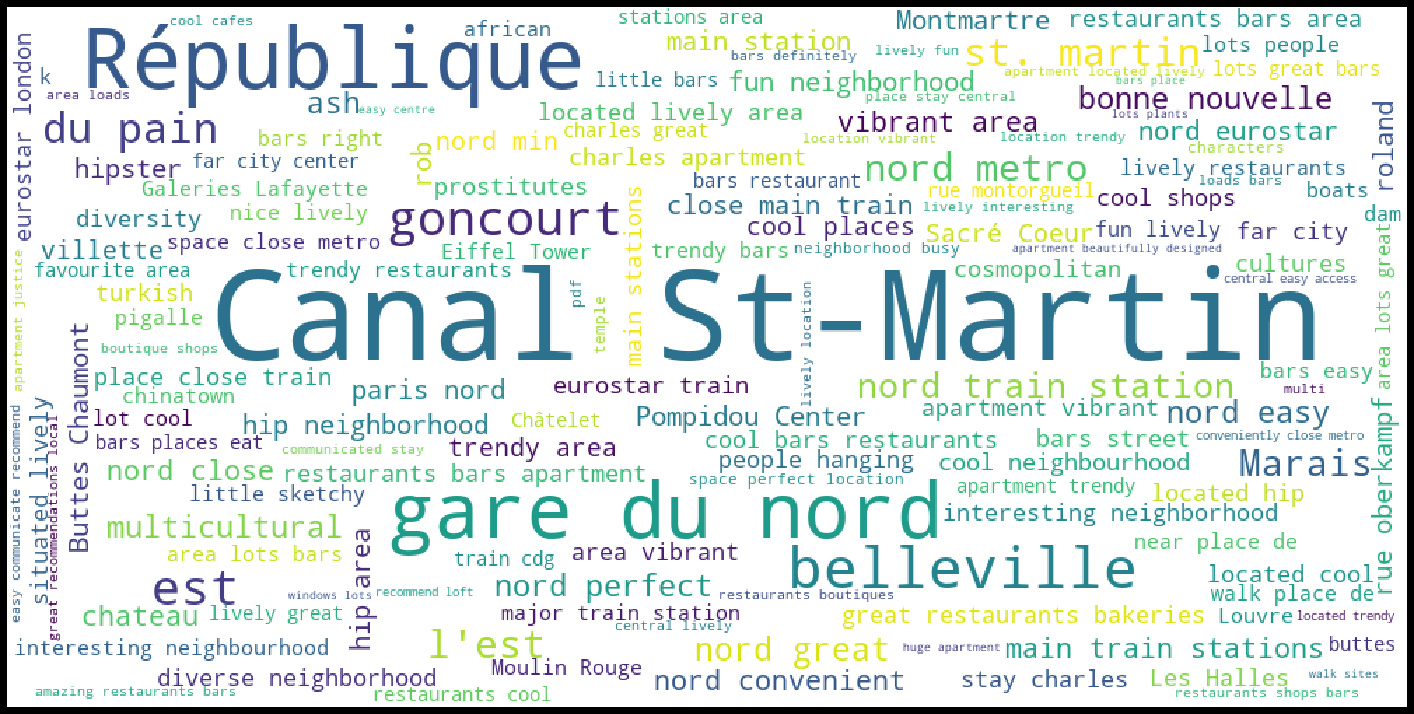



####################          GOBELINS:          ####################




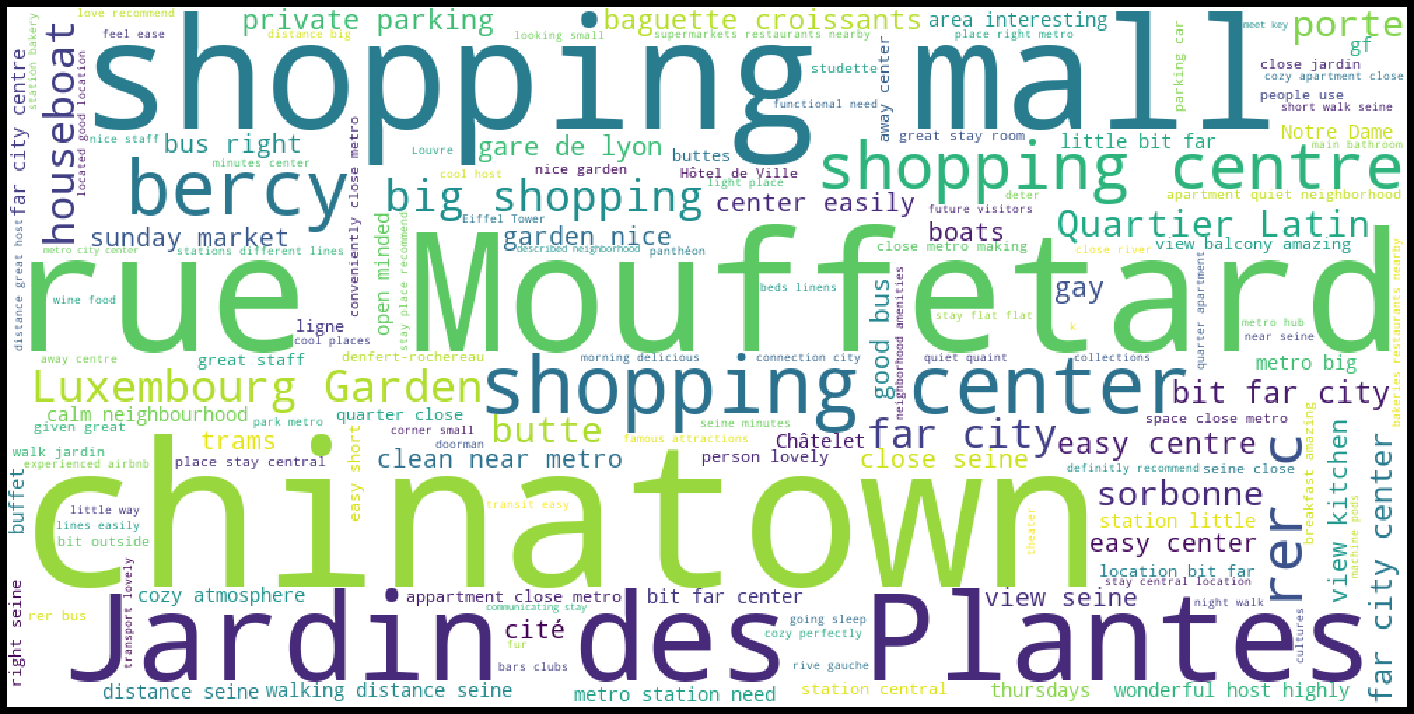



####################          HÔTEL-DE-VILLE:          ####################




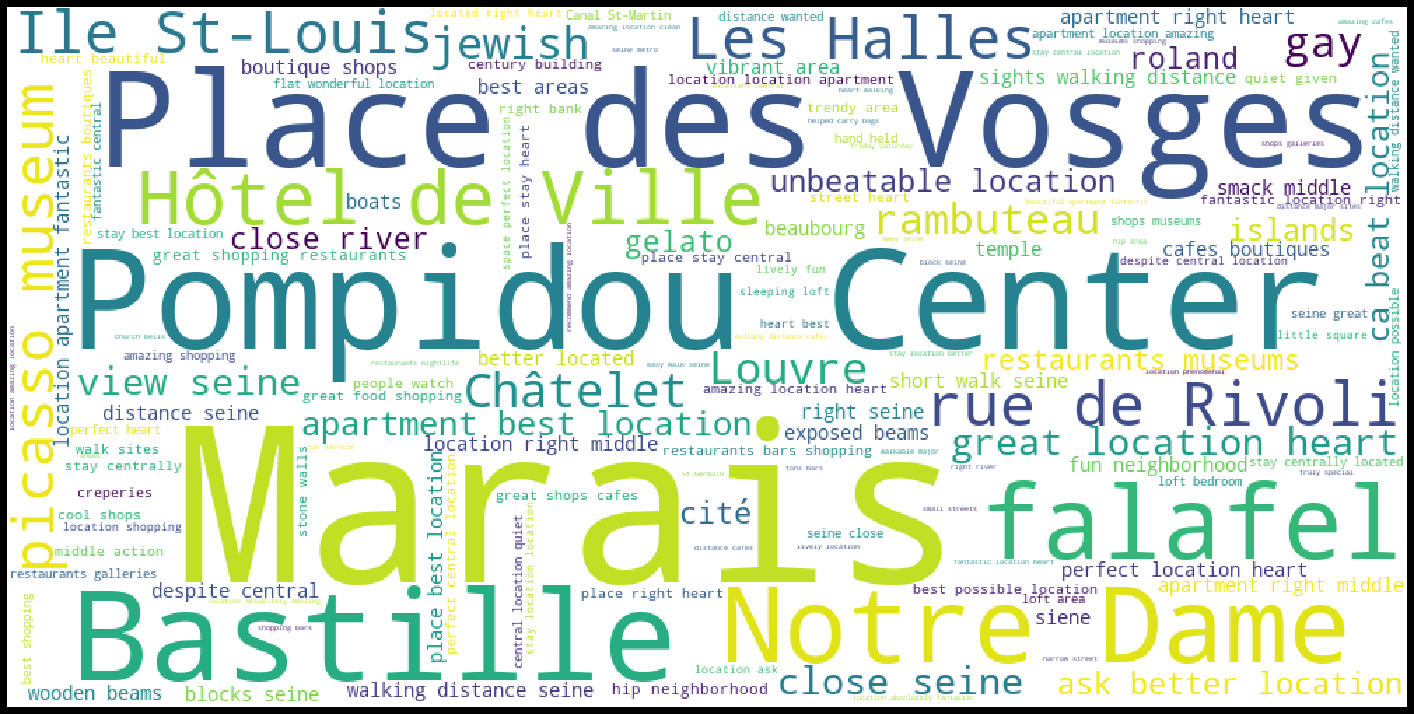



####################          LOUVRE:          ####################




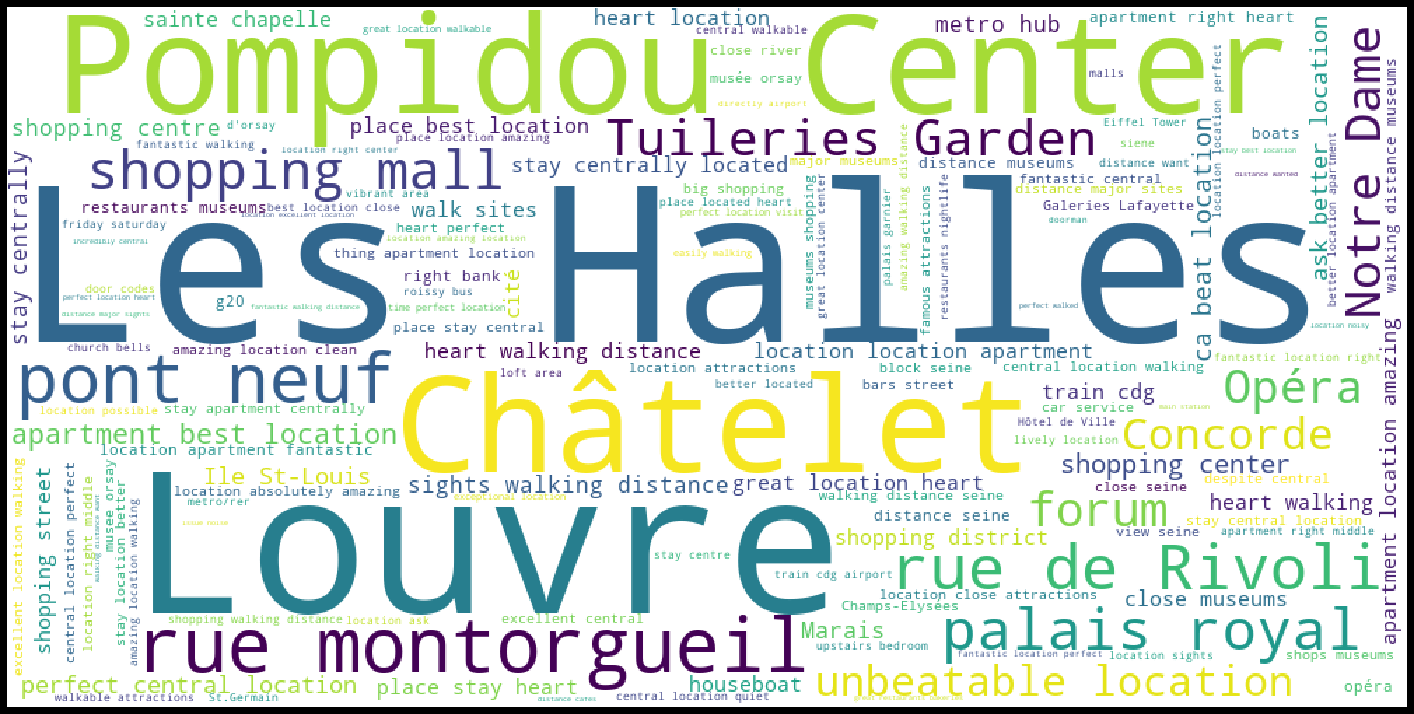



####################          LUXEMBOURG:          ####################




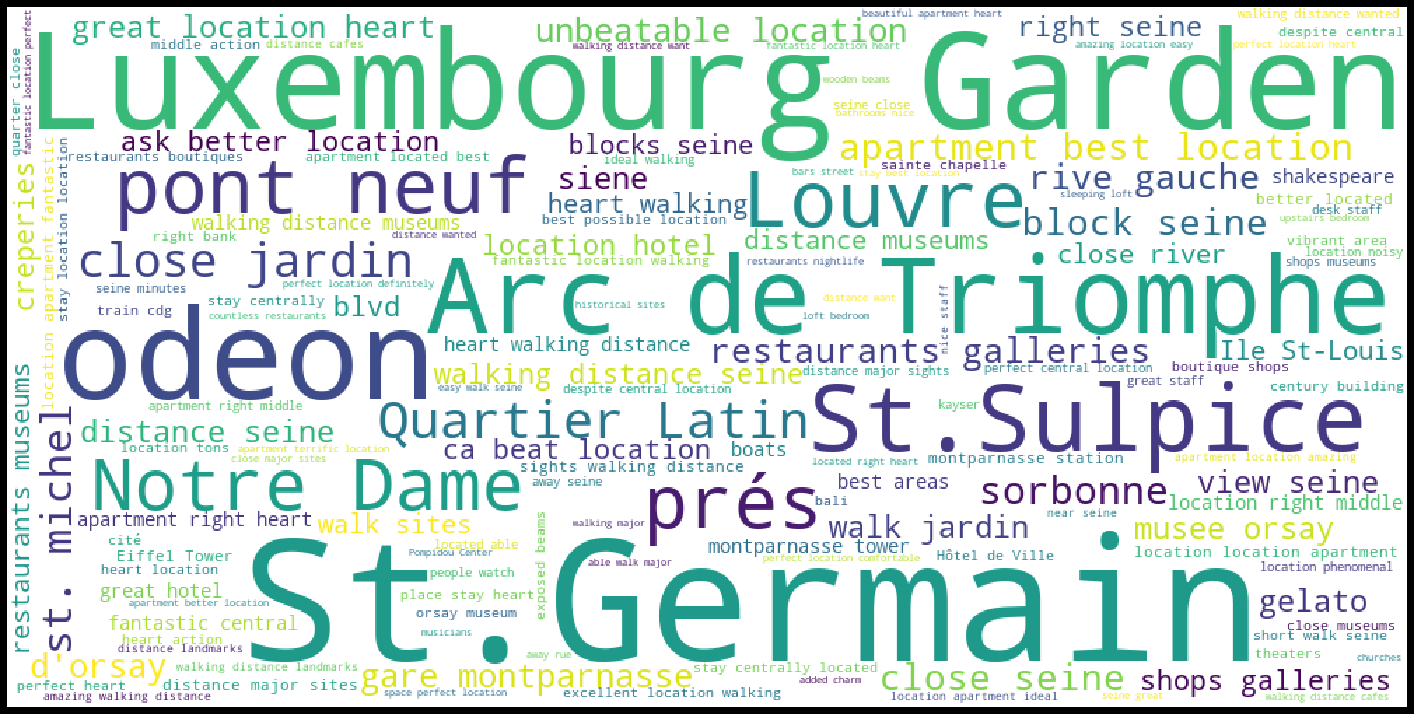



####################          MÉNILMONTANT:          ####################




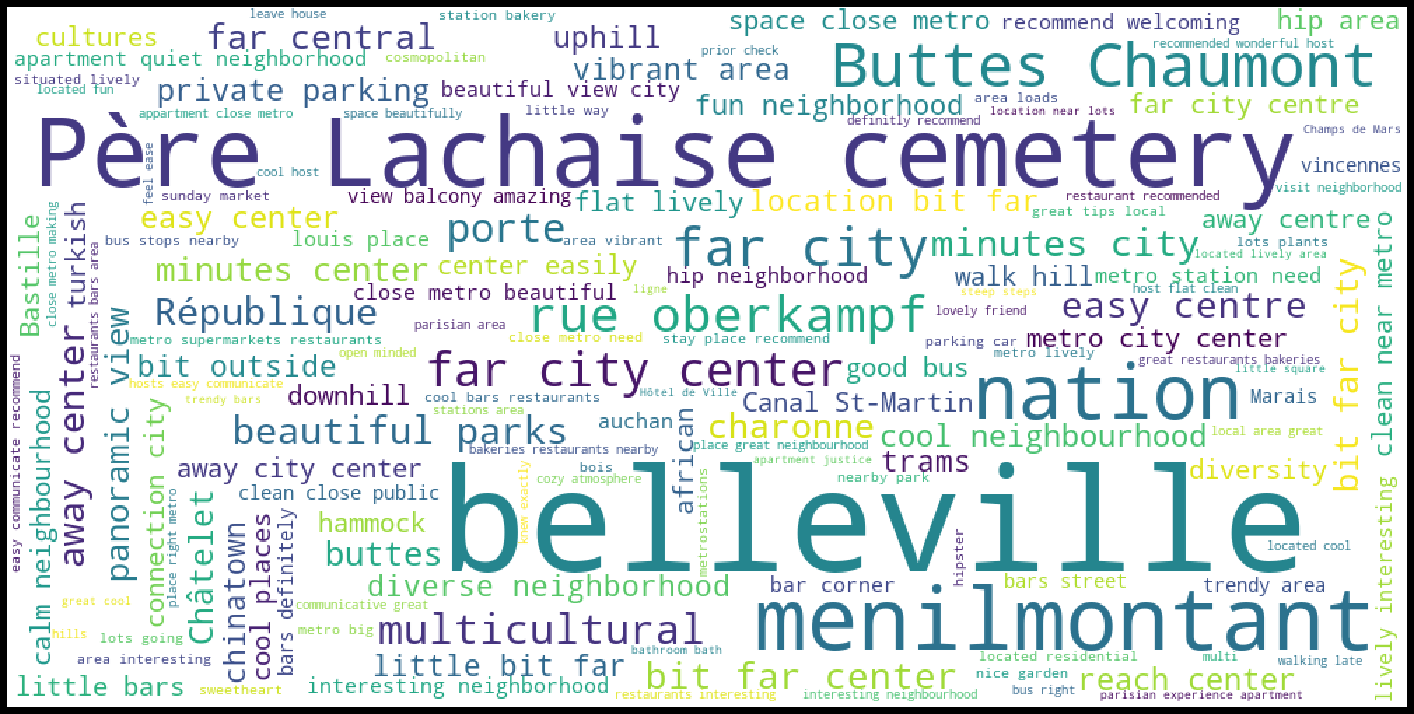



####################          OBSERVATOIRE:          ####################




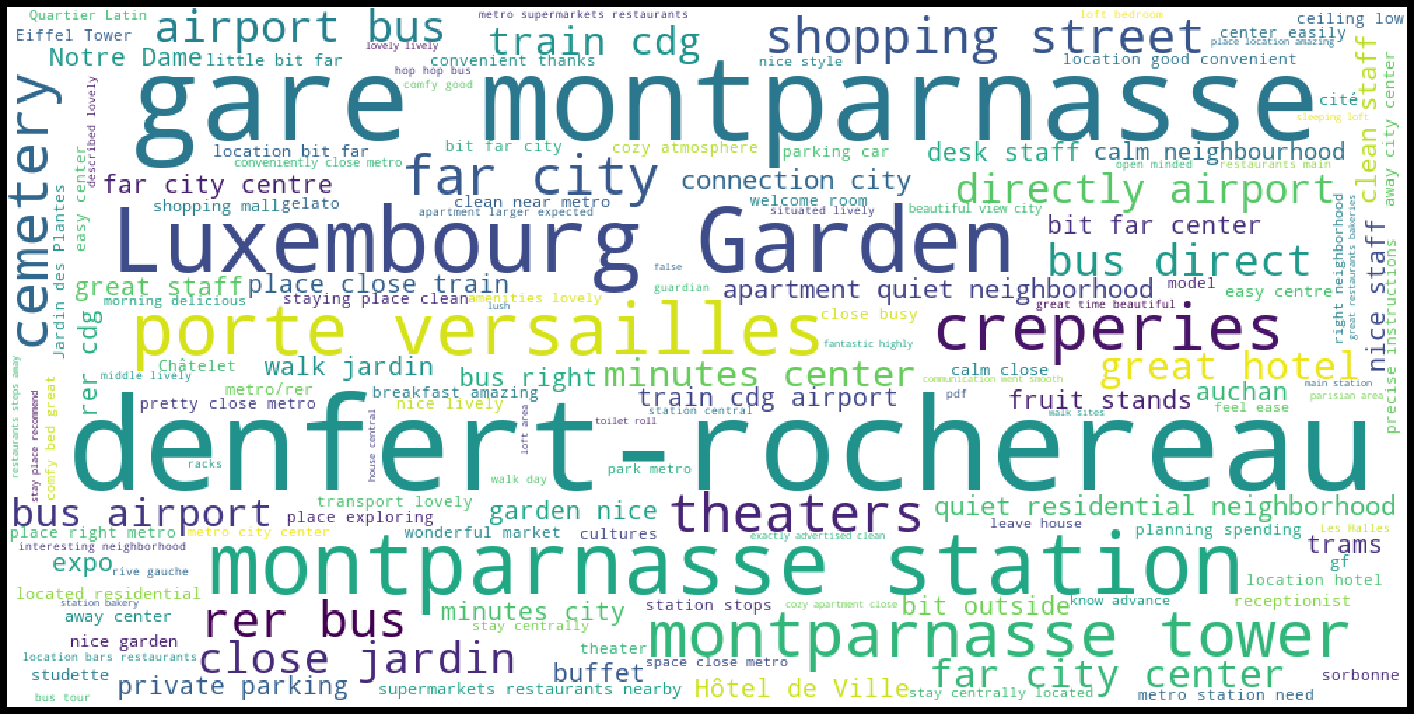



####################          OPÉRA:          ####################




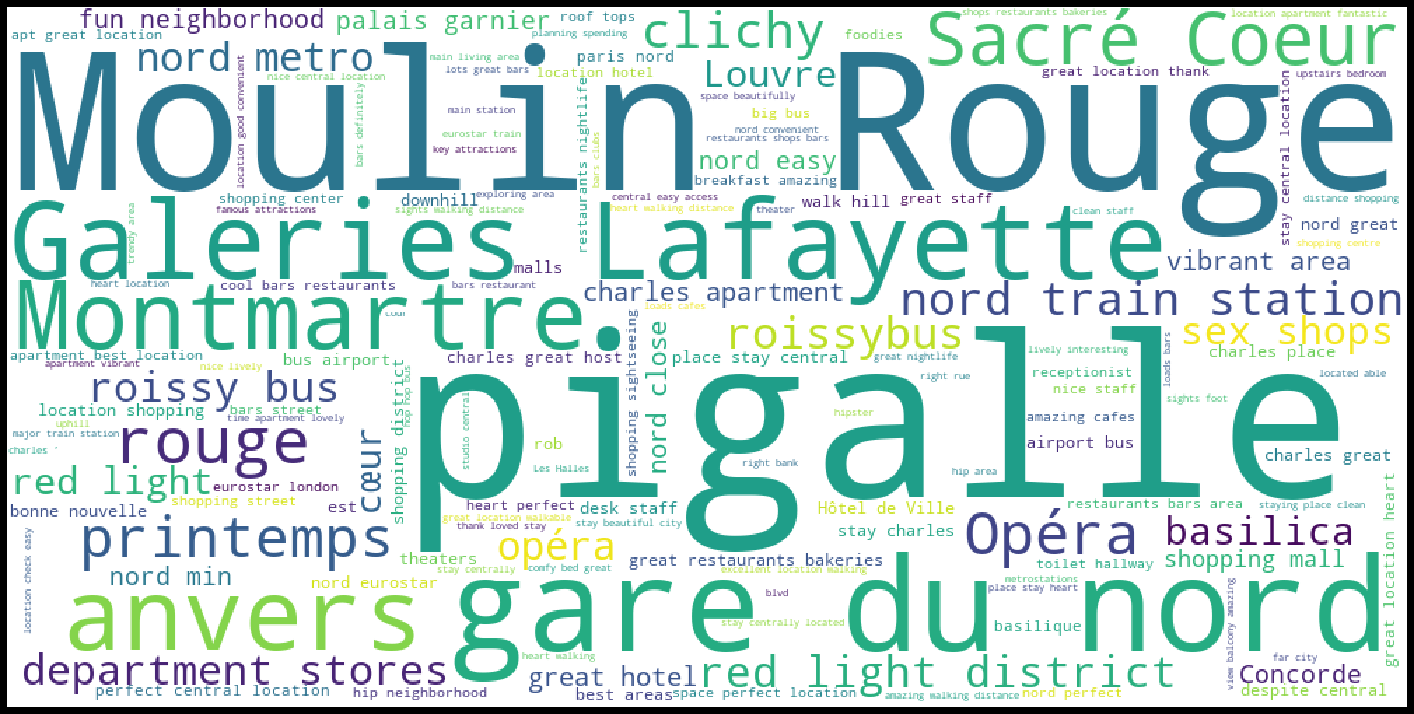



####################          PALAIS-BOURBON:          ####################




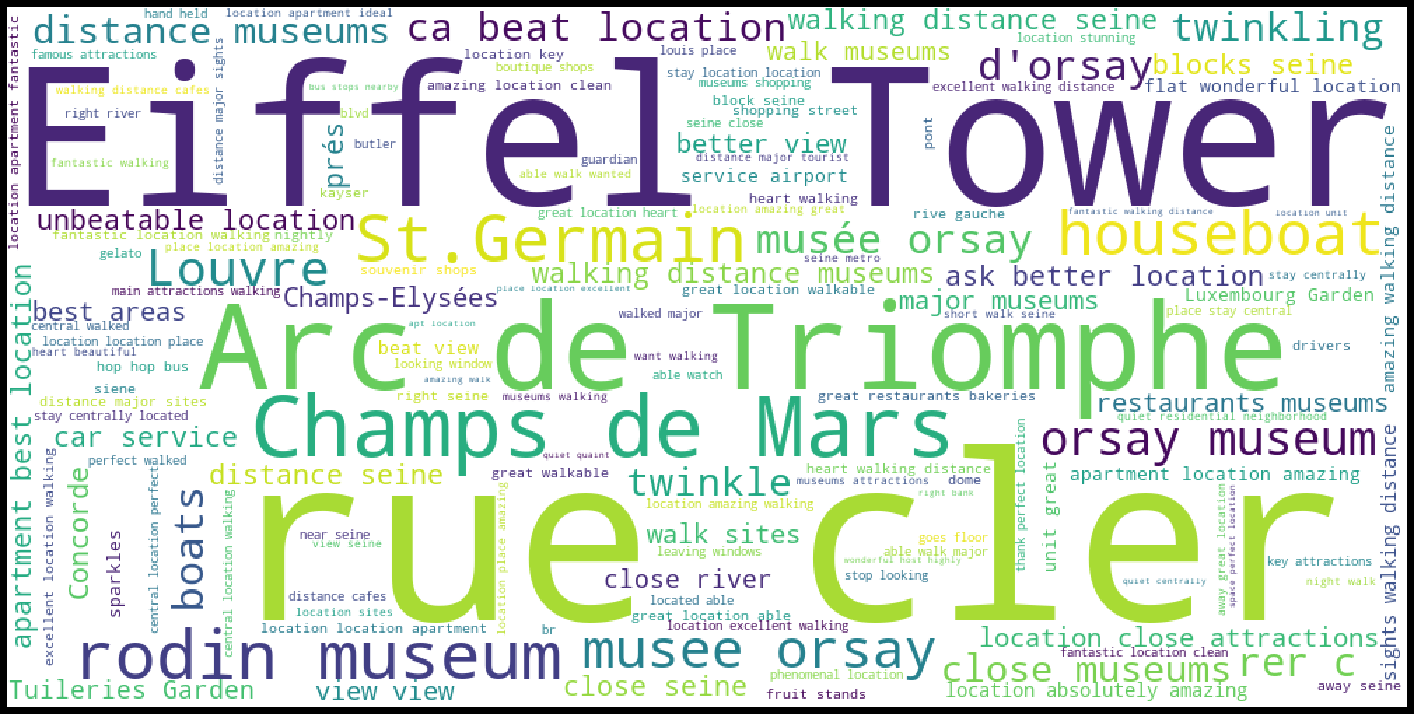



####################          PANTHÉON:          ####################




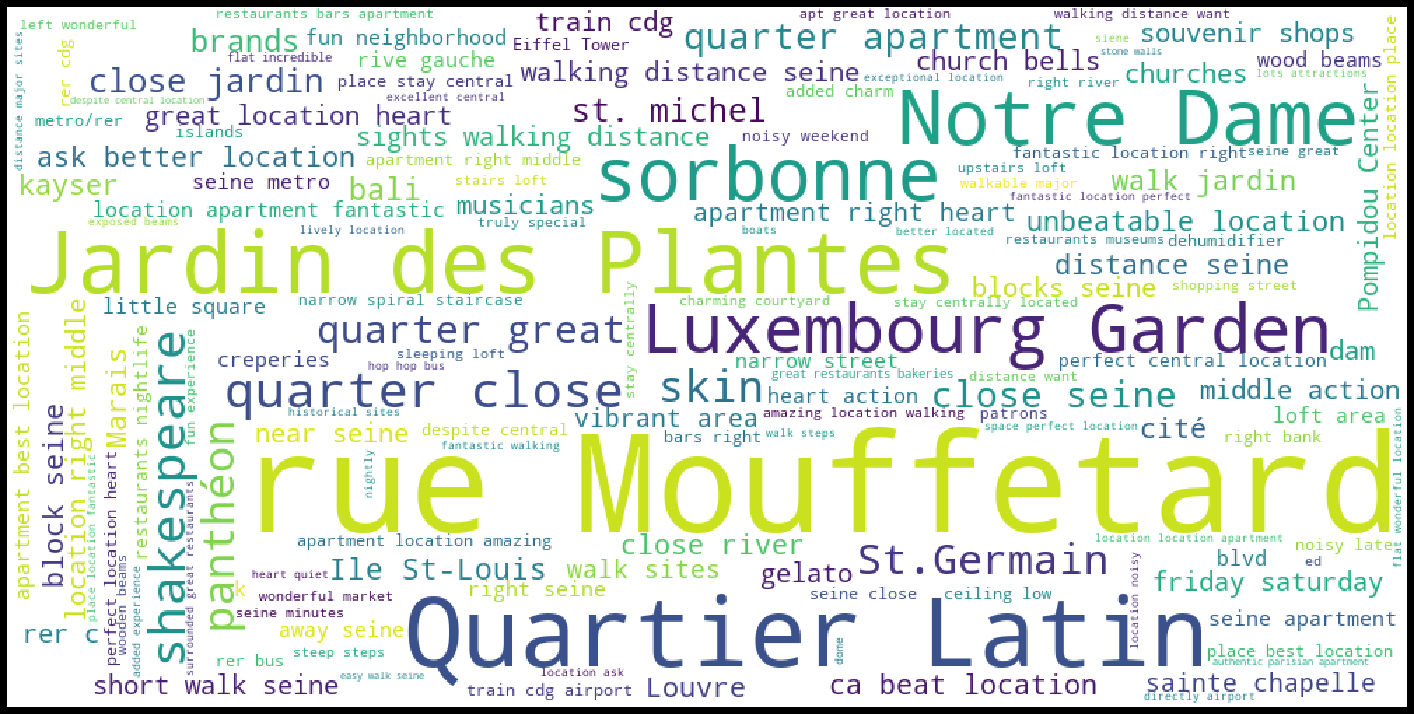



####################          PASSY:          ####################




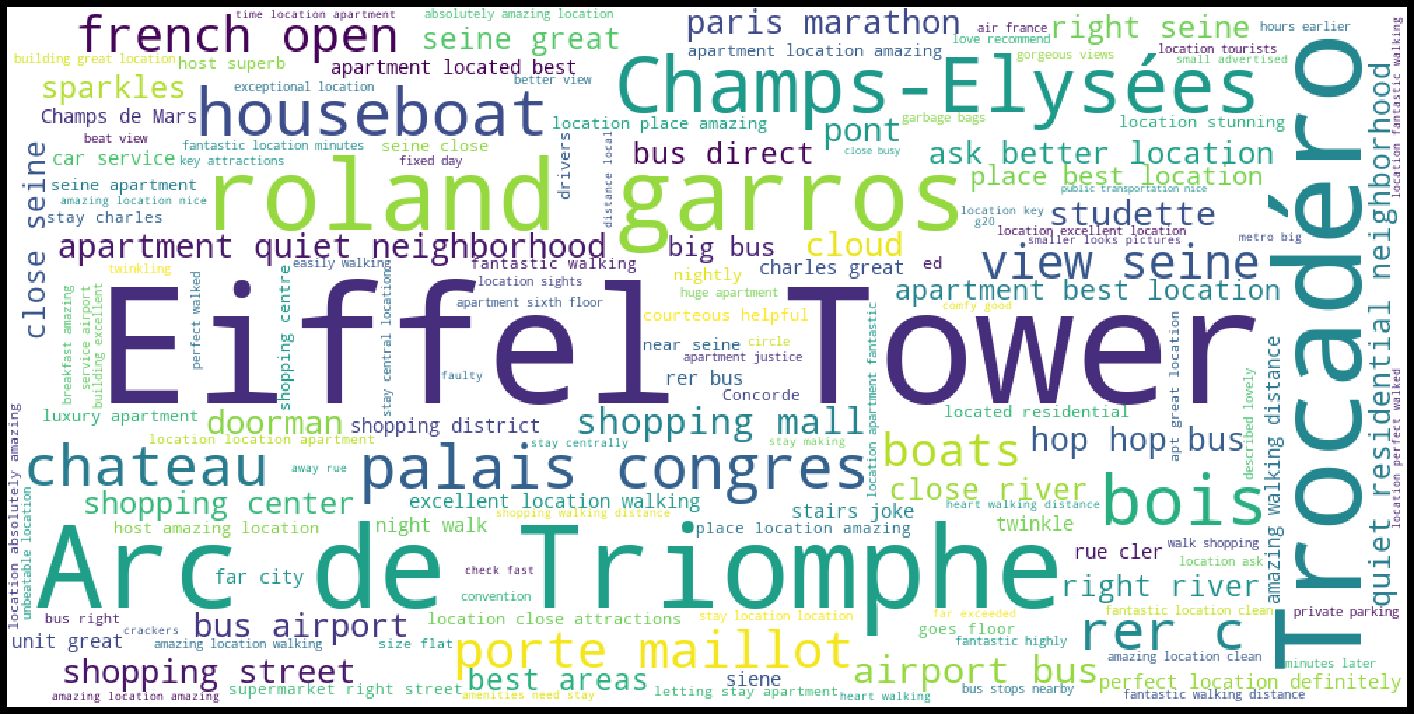



####################          POPINCOURT:          ####################




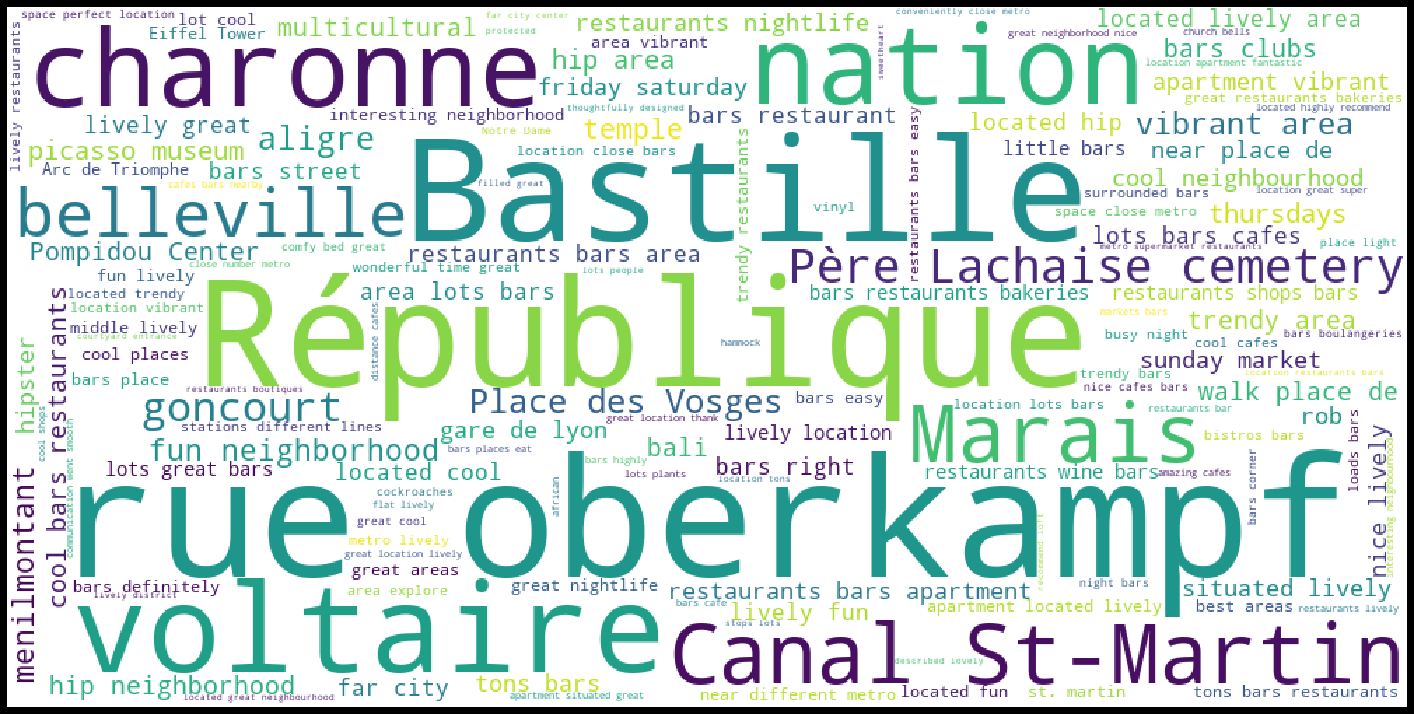



####################          REUILLY:          ####################




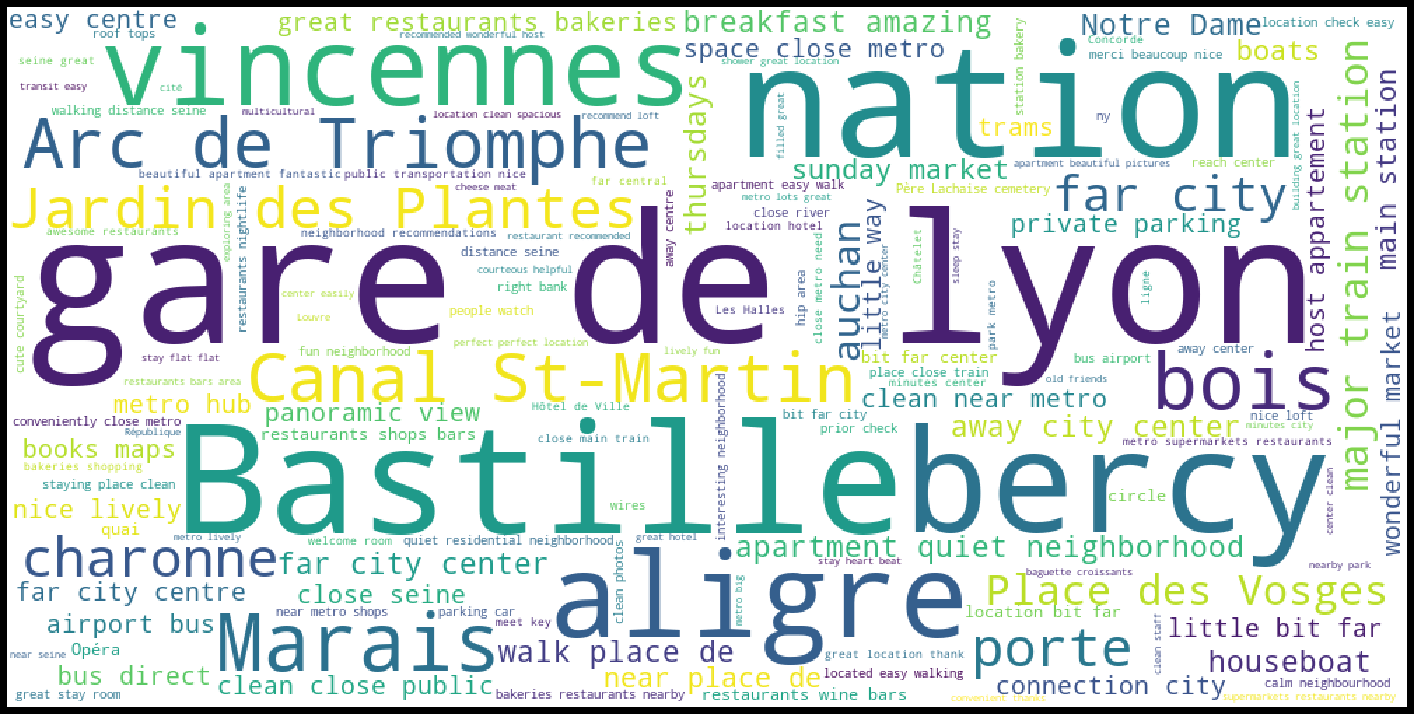



####################          TEMPLE:          ####################




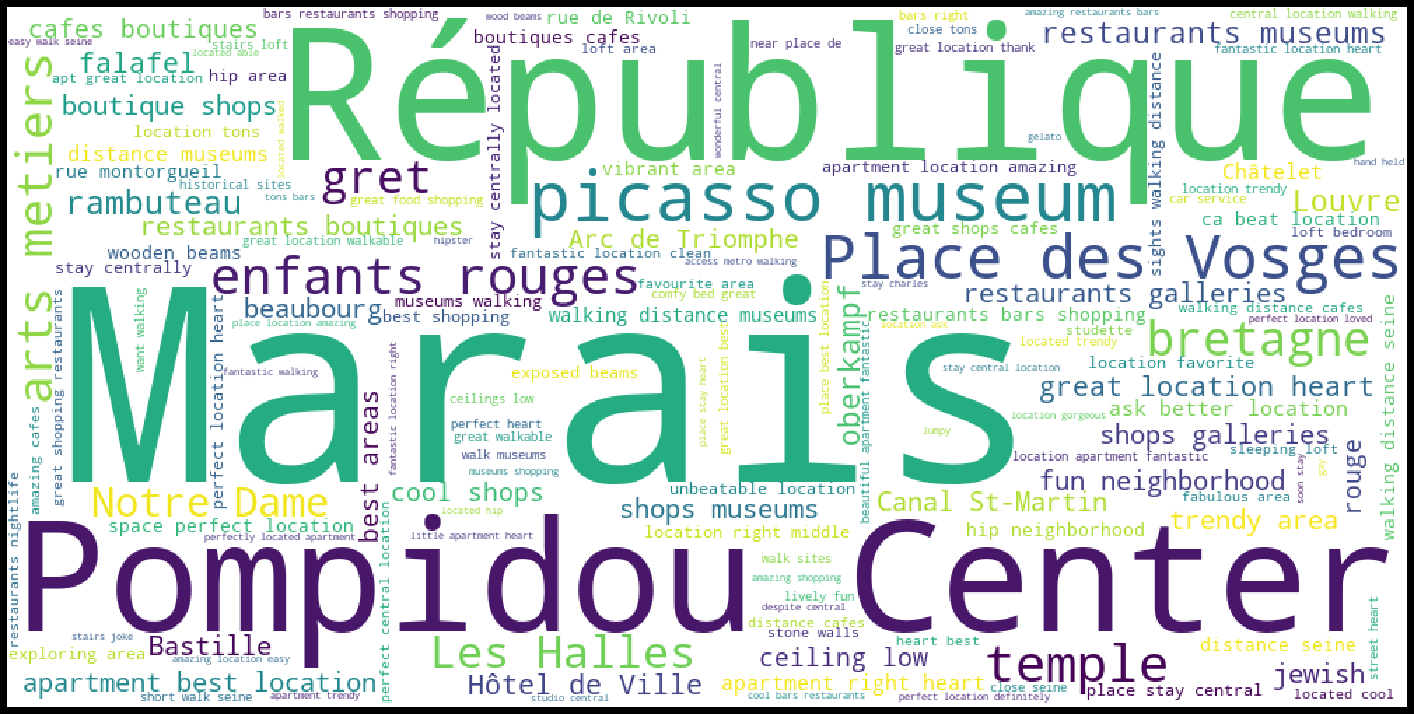



####################          VAUGIRARD:          ####################




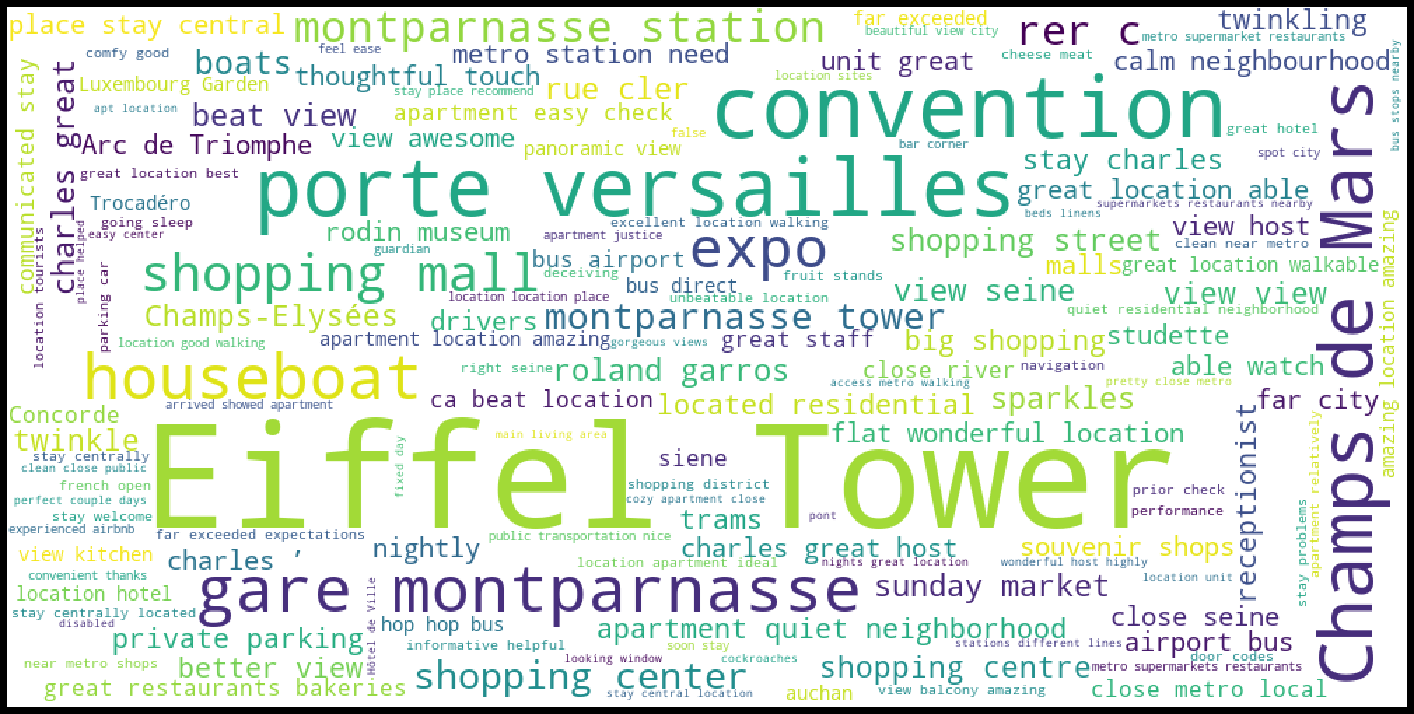



####################          ÉLYSÉE:          ####################




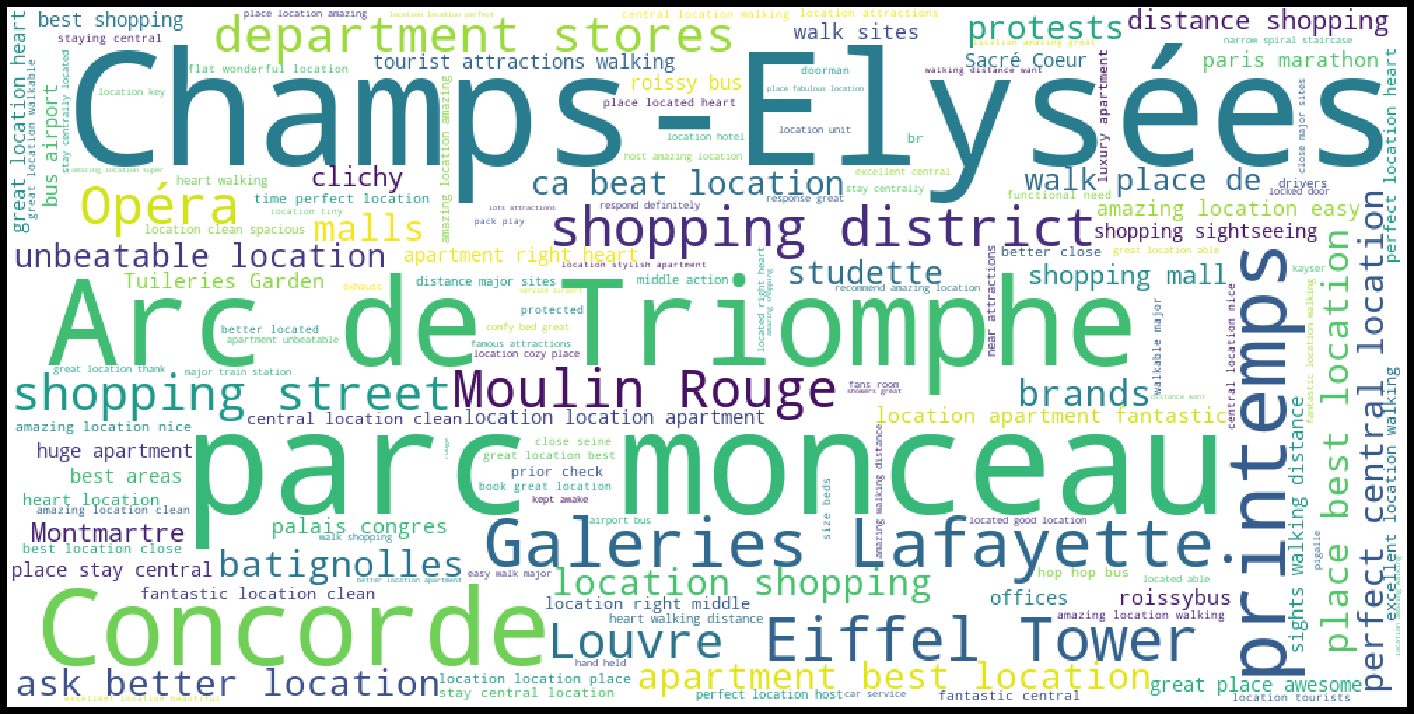

In [55]:
from wordcloud import WordCloud

for ngbh in vibrations_filtered.keys():
        
    print('\n')    
    print('#'*20+' '*10+ngbh.upper()+':'+' '*10 + '#'*20)
    print('\n')
    
    # Construct the wordcloud
    wordcloud = WordCloud(background_color="white", width=1000, height=500, max_words=150,\
                          contour_width=0.1, contour_color='steelblue')# Generate a word cloud
    wordcloud.generate_from_frequencies(dict(vibrations_filtered[ngbh]))
    wordcloud.to_image()

    # Plot the wordcloud
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=1)
    plt.show();